Sinh viên thực hiện:
 - Nguyễn Hoàng Hiệp - 15520214
 - Nguyễn Hoàng Luân - 

##1.Khai báo các thư viện cần thiết

In [0]:
# Imported Libraries
#Thư viện xử lý số
import numpy as np
import pandas as pd
from pandas import read_csv
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from timeit import default_timer as timer
import itertools
from scipy.stats import norm

# # Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections
from sklearn.preprocessing import StandardScaler, RobustScaler
from xgboost.sklearn import XGBClassifier
from imblearn.combine import SMOTEENN

# # Other Libraries
from imblearn.over_sampling import SMOTE
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.model_selection import train_test_split, RandomizedSearchCV

import warnings
warnings.filterwarnings("ignore")

In [0]:
# Hàm vẽ confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

##2.Kết nối vơi google driver và lấy dữ liệu
Cách này có thể chia sẻ cho mọi người có thể  thể chạy thử nghiệm

In [0]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# Download a file based on its file ID.
#  là id đường dẫn chia sẽ file tài liều
# example: https://drive.google.com/file/d/1rNwi9Ki1ujzHH4Q0rzXImW47tbZmR3Ds/view
# ID : 1rNwi9Ki1ujzHH4Q0rzXImW47tbZmR3Ds
file_id = '1rNwi9Ki1ujzHH4Q0rzXImW47tbZmR3Ds'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('creditcard.csv') # dowload file
# Đọc dữ liệu
data_raw = pd.read_csv('creditcard.csv')

In [0]:
# Link: https://drive.google.com/file/d/1ustrq4LwCMewdoDxf9SI89RaCxjn0ZLR/view?usp=sharing
file_id = '1ustrq4LwCMewdoDxf9SI89RaCxjn0ZLR'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('data_credit_undersampling.csv')
# Đọc dữ liệu
data_undersampling = pd.read_csv('data_credit_undersampling.csv')

##3.Hiểu dữ liệu - Understanding data

In [0]:
data_raw.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [0]:
data_raw.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [0]:
# Đếm số lượng giao dịch có dữ liệu null
data_raw.isnull().sum().max()

0

In [0]:
data_raw.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [0]:
# Số lượng trong các lớp cần phân loại
print('No Frauds', round(data_raw['Class'].value_counts()[0]/len(data_raw) * 100,2), '% of the dataset')
print('Frauds', round(data_raw['Class'].value_counts()[1]/len(data_raw) * 100,2), '% of the dataset')

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


Lưu ý: Cách mất cân bằng là tập dữ liệu gốc của chúng tôi!  Hầu hết các giao dịch là không gian lận.  Nếu chúng tôi sử dụng khung dữ liệu này làm cơ sở cho các mô hình và phân tích dự đoán của mình, chúng tôi có thể gặp rất nhiều lỗi và thuật toán của chúng tôi có thể sẽ phù hợp vì nó sẽ "cho rằng" hầu hết các giao dịch không phải là gian lận.  Nhưng chúng tôi không muốn mô hình của mình giả định, chúng tôi muốn mô hình của chúng tôi phát hiện các mô hình có dấu hiệu lừa đảo!

**Tóm lược:**

- Số tiền giao dịch tương đối nhỏ.  Giá trị trung bình của tất cả các gắn kết được thực hiện là khoảng 88 USD.
- Không có giá trị "Null", vì vậy chúng tôi không phải tìm cách thay thế giá trị.
- Hầu hết các giao dịch là Không gian lận (99,83%) trong khi giao dịch Gian lận xảy ra (017%) thời gian trong khung dữ liệu.

**Feature Technicalities:**  
- PCA Transformation: Mô tả dữ liệu nói rằng tất cả các tính năng đã trải qua chuyển đổi PCA (Kỹ thuật giảm kích thước) (Ngoại trừ thời gian và số tiền giao dịch).
- Scaling: Để thực hiện tính năng chuyển đổi PCA cần phải được thu nhỏ trước đó. (Trong trường hợp này, tất cả các tính năng V đã được thu nhỏ hoặc ít nhất đó là những gì chúng tôi giả định những người phát triển bộ dữ liệu đã làm.)

Text(0.5, 1.0, 'Phân Phối Lớp Phân Loại \n (0: Không gian lận || 1: Gian lận)')

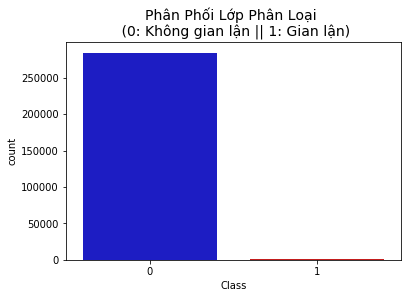

In [0]:
colors = ["#0101DF", "#DF0101"]

sns.countplot('Class', data=data_raw, palette=colors)
plt.title('Phân Phối Lớp Phân Loại \n (0: Không gian lận || 1: Gian lận)', fontsize=14)

Distributions (Phân phối):
- Bằng cách xem các bản phân phối, chúng ta có thể biết các tính năng này bị lệch như thế nào, chúng ta cũng có thể thấy các bản phân phối tiếp theo của các tính năng khác.  Có những kỹ thuật có thể giúp các bản phân phối ít bị sai lệch sẽ được thực hiện trong ở trong các phần sau.

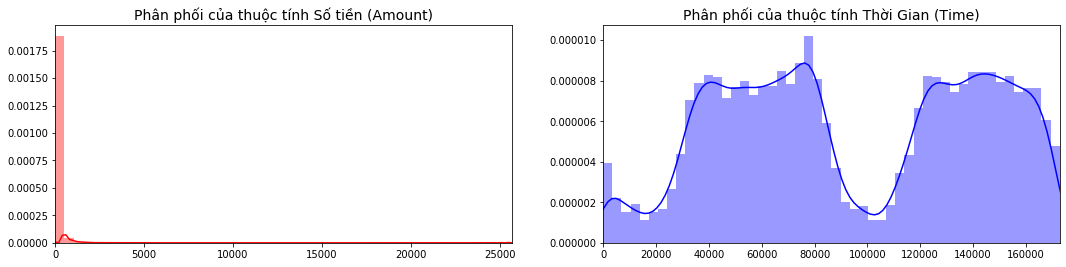

In [0]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = data_raw['Amount'].values
time_val = data_raw['Time'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Phân phối của thuộc tính Số tiền (Amount)', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Phân phối của thuộc tính Thời Gian (Time)', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

plt.show()

#4.Scaling and Distributing (Chia tỷ lệ và phân phối)

- Chúng tôi sẽ chia tỷ lệ các cột bao gồm `Thời gian` và Số tiền. Thời gian và số lượng nên được thu nhỏ như các cột khác.
- Chúng tôi cũng cần tạo một mẫu phụ(sub-sample) của bộ dữ liệu để có số lượng các trường hợp Gian lận và Không gian lận tương đương, giúp thuật toán của chúng tôi hiểu rõ hơn các mẫu xác định liệu giao dịch có lừa đảo hay không.

- Mẫu phụ (Sub-sample) là chúng tôi sẽ có bộ dữ liệu với tỷ 50/50 của các giao dịch gian lận và không gian lận.

- Chúng ta cần tạo sub-sample vì:
    - Overfitting: Các mô hình phân loại của chúng tôi sẽ cho rằng trong hầu hết các trường hợp không có gian lận! Những gì chúng tôi muốn cho mô hình của chúng tôi là phát hiện được gian lận.
    - Wrong Correlations: Mặc dù chúng tôi không biết các tính năng "V" là gì, nhưng sẽ hữu ích khi hiểu từng tính năng này ảnh hưởng đến kết quả như thế nào (Gian lận hoặc Không gian lận) bằng cách có một khung dữ liệu mất cân bằng mà chúng tôi không thể thấy được mối tương quan thực sự giữa các lớp và tính năng.

**Tóm lượt:**
- Có 492 trường hợp gian lận trong bộ dữ liệu của chúng tôi để chúng tôi có thể lấy ngẫu nhiên 492 trường hợp không gian lận để tạo khung dữ liệu phụ mới của chúng tôi.
- Chúng tôi kết hợp 492 trường hợp gian lận và không gian lận, tạo ra một mẫu phụ mới.

In [0]:
# ***
std_scaler = StandardScaler()
rob_scaler = RobustScaler()
# 
data_raw['scaled_amount'] = rob_scaler.fit_transform(data_raw['Amount'].values.reshape(-1,1))
data_raw['scaled_time'] = rob_scaler.fit_transform(data_raw['Time'].values.reshape(-1,1))

data_raw.drop(['Time','Amount'], axis=1, inplace=True)

In [0]:
scaled_amount = data_raw['scaled_amount']
scaled_time = data_raw['scaled_time']

data_raw.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
data_raw.insert(0, 'scaled_amount', scaled_amount)
data_raw.insert(1, 'scaled_time', scaled_time)

data_raw.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


#5.Tách dữ liệu (Splitting the Data)

Trước khi tiến hành kỹ thuật Lấy mẫu ngẫu nhiên, chúng tôi phải tách khung dữ liệu ban đầu.  Với mục đích thử nghiệm, hãy nhớ rằng mặc dù chúng tôi đang phân tách dữ liệu khi triển khai các kỹ thuật Lấy mẫu ngẫu nhiên(Random UnderSampling) hoặc Lấy mẫu quá mức(Random Oversampling). Mục tiêu là để để các mô hình của chúng tôi phát hiện các giao dịch gian lận và kiểm tra nó trên bộ thử nghiệm ban đầu (Dữ liệu mà nó chưa từng thấy).

In [0]:
print('No Frauds', round(data_raw['Class'].value_counts()[0]/len(data_raw) * 100,2), '% of the dataset')
print('Frauds', round(data_raw['Class'].value_counts()[1]/len(data_raw) * 100,2), '% of the dataset')

X = data_raw.drop('Class', axis=1)
y = data_raw['Class']

original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(
    X, y, test_size=0.33, random_state=42, stratify=y)

# Check the Distribution of the labels
# Chuyển đổi thành một mảng
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

#
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 80)

print('Phân phối nhãn phân loại:')
print(train_counts_label / len(original_ytrain))
print(test_counts_label / len(original_ytest))

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset
--------------------------------------------------------------------------------
Phân phối nhãn phân loại:
[0.99827062 0.00172938]
[0.99827636 0.00172364]


#6.Kỹ thuật lấy mẫu ngẫu nhiên dưới mức (Random Under-Sampling)

- Chúng tôi sẽ thực hiện kỹ thuật "Lấy mẫu ngẫu nhiên", về cơ bản bao gồm xóa dữ liệu để có bộ dữ liệu cân bằng hơn và do đó tránh các mô hình của chúng tôi bị quá mức.

Các bước thực hiện:**bold text**
- Điều đầu tiên chúng ta phải làm là xác định mức độ mất cân bằng của lớp chúng ta (sử dụng "value_counts ()" trên cột lớp để xác định số lượng cho mỗi nhãn)
- Khi chúng tôi xác định có bao nhiêu trường hợp được coi là giao dịch gian lận (Gian lận = "1"), chúng tôi nên xóa các giao dịch không gian lận cho đến khi cùng số lượng với các giao dịch gian lận (giả sử chúng tôi muốn tỷ lệ 50/50), điều này sẽ tương đương với 492  các trường hợp gian lận và 492 trường hợp giao dịch không gian lận.
- Sau khi thực hiện kỹ thuật này, chúng tôi có một mẫu phụ của khung dữ liệu của chúng tôi với tỷ lệ 50/50 liên quan đến các lớp của chúng tôi.  Sau đó, bước tiếp theo chúng tôi sẽ thực hiện là xáo trộn dữ liệu để xem liệu các mô hình của chúng tôi có thể duy trì độ chính xác nhất định mỗi khi chúng tôi chạy lại tập lệnh này hay không.

**Lưu ý**: Vấn đề chính với "Lấy mẫu ngẫu nhiên dưới mức" là chúng tôi gặp rủi ro là các mô hình phân loại của chúng tôi sẽ không hoạt động chính xác như chúng tôi mong muốn vì có rất nhiều thông tin bị mất mát  (Chỉ còn 492 giao dịch không gian lận từ 284.315  giao dịch không gian lận), các dữ liệu bị xóa đi có thể chứ nhiều thông tin có ích.

In [0]:
# Xáo trộn dữ liệu
data_raw = data_raw.sample(frac=1)

# Số lượng giao dịch gian lận là 492 dòng.
fraud_df = data_raw.loc[data_raw['Class'] == 1]
non_fraud_df = data_raw.loc[data_raw['Class'] == 0][:492]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Xáo trộn dữ liệu một lần nữa
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
271994,-0.098512,0.941811,1.952612,0.570243,-1.635657,3.611706,0.994265,-0.204485,0.630400,-0.118109,-1.317378,1.749963,-0.280662,-0.717751,-1.991944,1.106379,-1.738863,0.647026,-0.841214,0.135030,-0.872801,-0.390037,0.120371,0.293366,-0.072331,-0.538103,0.388742,0.187553,-0.096714,-0.085099,0
100623,7.364773,-0.201142,-0.758469,-0.045410,-0.168438,-1.313275,-1.901763,0.739433,3.071892,-0.483422,0.618203,-1.769060,-0.651414,-0.005423,-0.517194,0.217470,0.883559,-1.173978,0.243347,-0.342301,0.687056,-0.032500,0.042619,0.397224,0.072229,-0.242276,0.560916,-0.540955,0.150606,-0.117140,1
37421,17.622860,-0.537389,-1.245076,-4.678746,-0.509095,0.804979,-2.527825,0.327461,0.684009,-0.003134,0.981389,-0.658852,0.429093,-0.490091,-2.330822,0.624616,0.505624,0.975261,-0.388079,0.988906,0.088577,2.407453,0.828271,-0.525467,-1.156076,0.115803,-0.413953,1.365036,-0.327431,0.212233,0
151008,-0.293440,0.113606,-26.457745,16.497472,-30.177317,8.904157,-17.892600,-1.227904,-31.197329,-11.438920,-9.462573,-22.187089,4.419997,-10.592305,-0.703796,-3.926207,-2.400246,-6.809890,-12.462315,-5.501051,-0.567940,2.812241,-8.755698,3.460893,0.896538,0.254836,-0.738097,-0.966564,-7.263482,-1.324884,1
15225,1.089779,-0.682656,-19.856322,12.095893,-22.464083,6.115541,-15.148022,-4.346724,-15.648507,13.276805,-3.974162,-8.859194,5.730816,-8.088034,0.230825,-8.578973,0.000947,-6.947746,-13.472897,-4.940211,1.230143,1.582930,1.750730,-1.409636,-0.809809,0.121397,1.350300,-0.224292,1.597621,0.476920,1


Phân phối của các nhãn phân loại trong tệp dữ liệu mới
1    0.5
0    0.5
Name: Class, dtype: float64


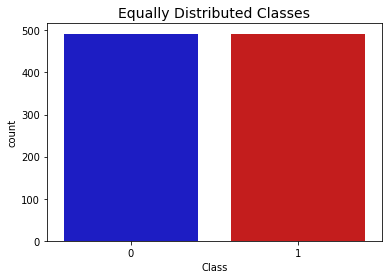

In [0]:
print('Phân phối của các nhãn phân loại trong tệp dữ liệu mới')
print(new_df['Class'].value_counts()/len(new_df))
colors = ["#0101DF", "#DF0101"]
sns.countplot('Class', data=new_df, palette=colors)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

##6.1 Ma trận tương quan (Correlation Matrices)

- Ma trận tương quan là bản chất của việc hiểu dữ liệu của chúng tôi.  Chúng tôi muốn biết liệu có những tính năng ảnh hưởng lớn đến việc một giao dịch cụ thể có phải là lừa đảo hay không. Tuy nhiên, điều quan trọng là chúng tôi sử dụng đúng tệp dữ liệu (undersampling) để chúng tôi xem các tính năng nào có mối tương quan thuận hoặc ngược cao liên quan đến các giao dịch gian lận.

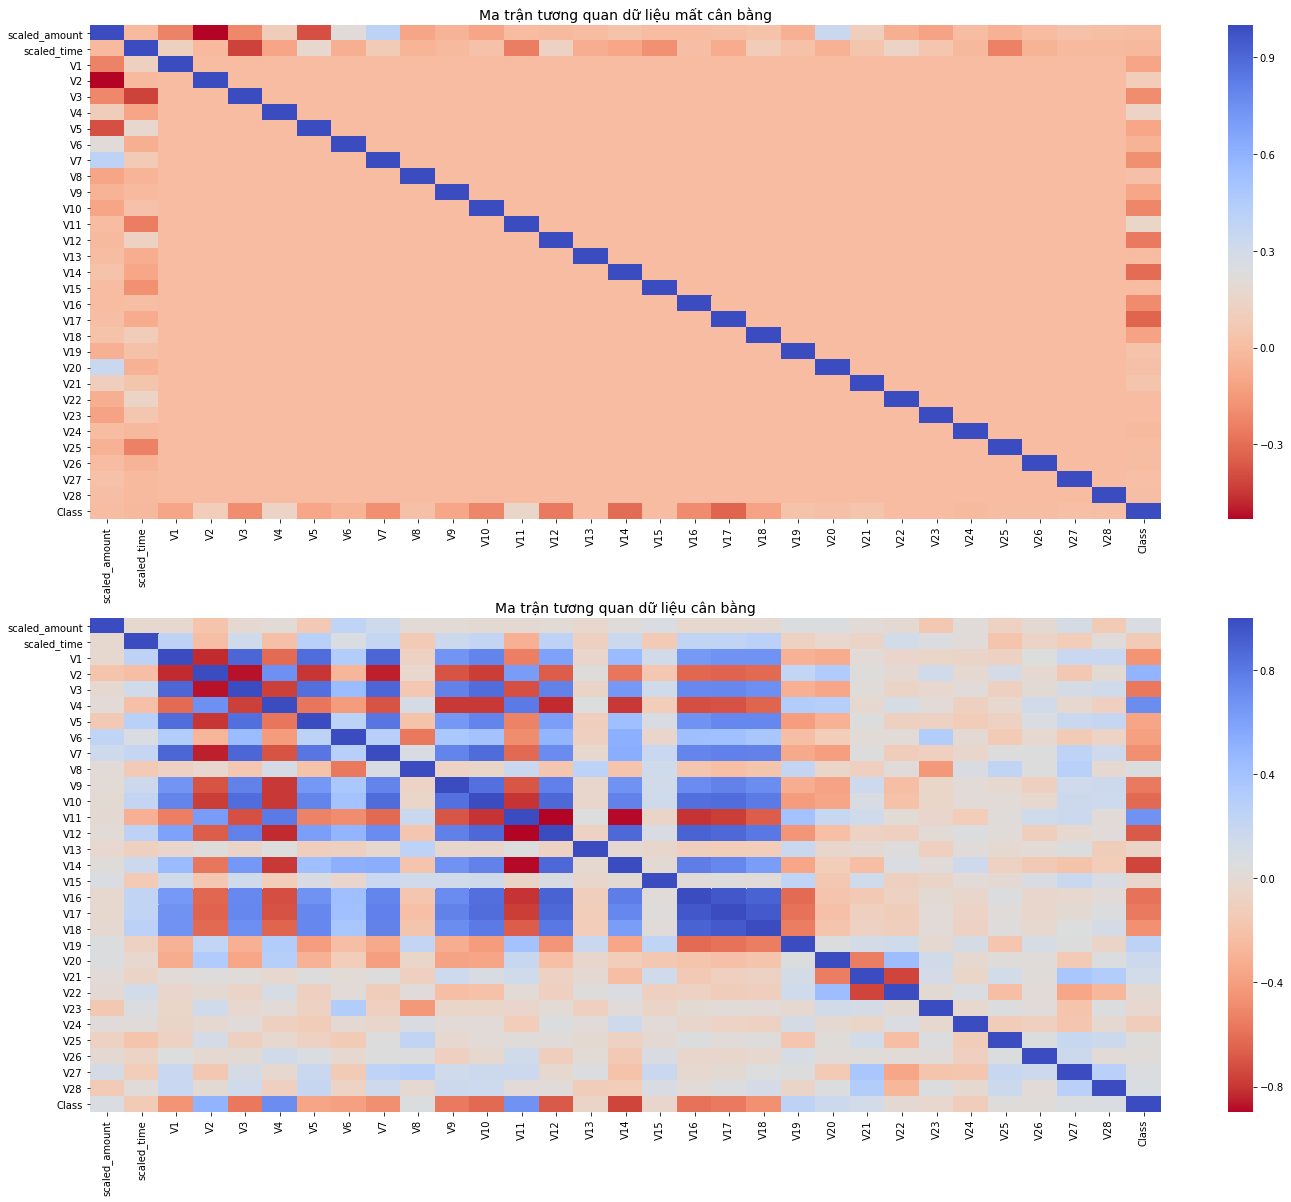

In [0]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

# Toàn bộ dữ liệu
corr = data_raw.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Ma trận tương quan dữ liệu mất cân bằng", fontsize=14)

# Dữ bộ dữ liệu undersampling
sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('Ma trận tương quan dữ liệu cân bằng', fontsize=14)
plt.show()

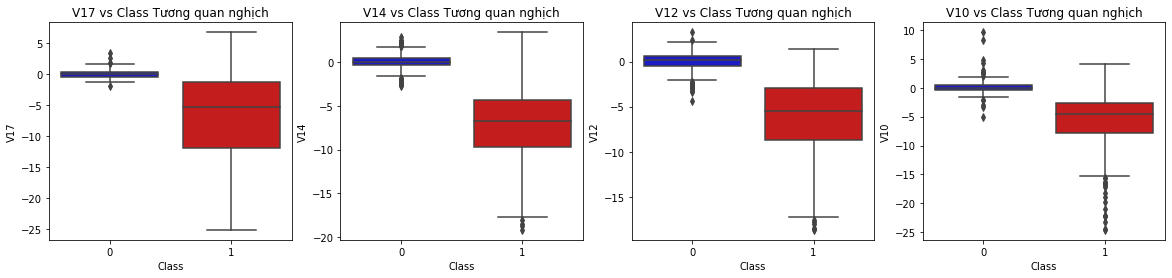

In [0]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

sns.boxplot(x="Class", y="V17", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('V17 vs Class Tương quan nghịch')

sns.boxplot(x="Class", y="V14", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('V14 vs Class Tương quan nghịch')


sns.boxplot(x="Class", y="V12", data=new_df, palette=colors, ax=axes[2])
axes[2].set_title('V12 vs Class Tương quan nghịch')


sns.boxplot(x="Class", y="V10", data=new_df, palette=colors, ax=axes[3])
axes[3].set_title('V10 vs Class Tương quan nghịch')

plt.show()

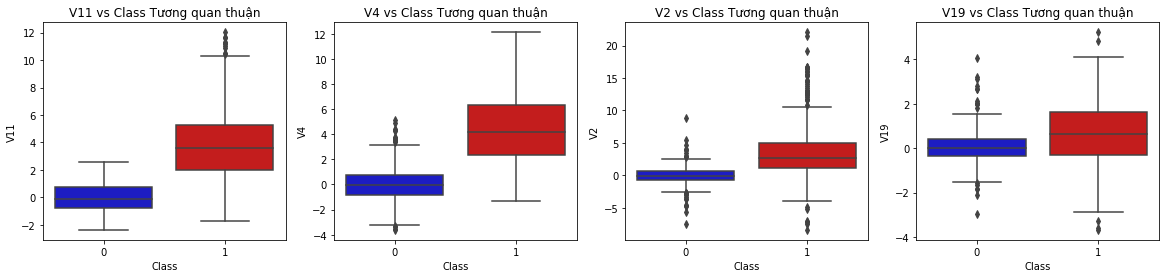

In [0]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

sns.boxplot(x="Class", y="V11", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('V11 vs Class Tương quan thuận')

sns.boxplot(x="Class", y="V4", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('V4 vs Class Tương quan thuận')

sns.boxplot(x="Class", y="V2", data=new_df, palette=colors, ax=axes[2])
axes[2].set_title('V2 vs Class Tương quan thuận')

sns.boxplot(x="Class", y="V19", data=new_df, palette=colors, ax=axes[3])
axes[3].set_title('V19 vs Class Tương quan thuận')

plt.show()

**Tóm tắt và giải thích**:
- Tương quan ngược: các thuộc tính V17, V14, V12 và V10 có mối tương quan ngược chiều. Lưu ý rằng các giá trị này càng thấp thì kết quả cuối cùng sẽ là một giao dịch gian lận.
- Tương quan tích cực: V2, V4, V11 và V19 có mối tương quan tích cực.  Lưu ý rằng các giá trị này càng cao thì kết quả cuối cùng sẽ là một giao dịch gian lận.
- Biểu đồ hộp (BoxPlots): Chúng tôi sẽ sử dụng biểu đồ hộp để hiểu rõ hơn về việc phân phối các tính năng này trong các giao dịch gian lận và không gian lận.

##6.2 Phát hiện bất thường (Anomaly Detection)


- Mục đích của chúng tôi là loại bỏ "các ngoại lệ cực đoan" khỏi các tính năng có mối tương quan cao với các nhãn của chúng tôi. Điều này sẽ có tác động tích cực đến độ chính xác của các mô hình của chúng tôi.

**Phương pháp phạm vi liên vùng (Interquartile Range Method):**
- Phạm vi liên vùng (IQR): Chúng tôi tính toán điều này bằng sự khác biệt giữa phân vị thứ 75 và phân vị thứ 25. Mục đích của chúng tôi là tạo ra một ngưỡng vượt quá tỷ lệ phần trăm thứ 75 và 25 mà trong trường hợp một số trường hợp vượt qua ngưỡng này, có thể sẽ bị xóa.
- Biểu đồ hộp (Boxplots): Bên cạnh việc dễ dàng nhìn thấy các phần trăm thứ 25 và 75 (cả hai đầu của hình vuông), chúng ta cũng dễ dàng nhìn thấy các ngoại lệ cực đoan (các điểm nằm ngoài cực thấp và cực cao hơn).

**Lưu ý:**
Chúng ta phải cẩn thận về ngưỡng để loại bỏ các ngoại lệ. Chúng tôi xác định ngưỡng bằng cách nhân một số (ví dụ: 1,5) với (Phạm vi liên dải).  Ngưỡng này càng cao, càng ít ngoại lệ sẽ phát hiện và ngưỡng này càng thấp thì càng phát hiện ra nhiều ngoại lệ.

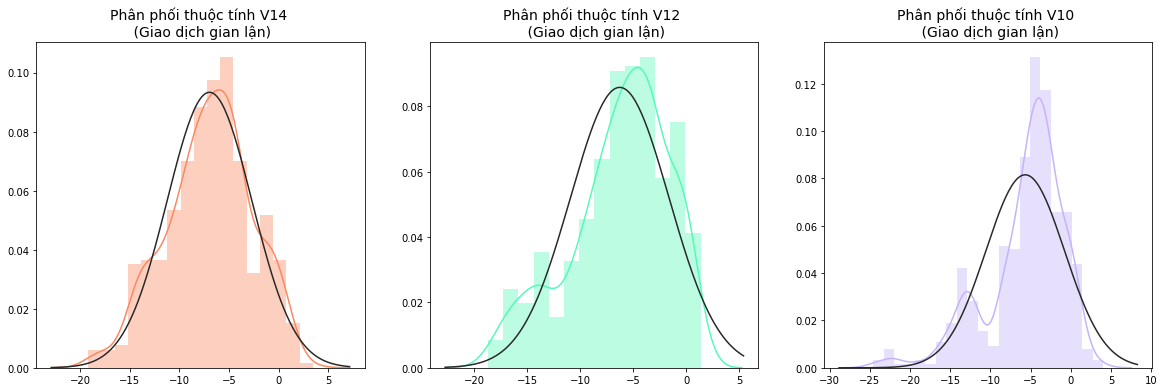

In [0]:
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 6))

v14_fraud_dist = new_df['V14'].loc[new_df['Class'] == 1].values
sns.distplot(v14_fraud_dist,ax=ax1, fit=norm, color='#FB8861')
ax1.set_title('Phân phối thuộc tính V14 \n (Giao dịch gian lận)', fontsize=14)

v12_fraud_dist = new_df['V12'].loc[new_df['Class'] == 1].values
sns.distplot(v12_fraud_dist,ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('Phân phối thuộc tính V12 \n (Giao dịch gian lận)', fontsize=14)


v10_fraud_dist = new_df['V10'].loc[new_df['Class'] == 1].values
sns.distplot(v10_fraud_dist,ax=ax3, fit=norm, color='#C5B3F9')
ax3.set_title('Phân phối thuộc tính V10 \n (Giao dịch gian lận)', fontsize=14)

plt.show()

In [0]:
# # -----> V14 xóa giá trị ngoại vi khỏi các giao dịch gian lận
v14_fraud = new_df['V14'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v14_fraud, 25), np.percentile(v14_fraud, 75)
print('Bách phân bị 25: {} | Bách phân vị 75: {}'.format(q25, q75))
v14_iqr = q75 - q25
print('iqr: {}'.format(v14_iqr))

v14_cut_off = v14_iqr * 1.5
v14_lower, v14_upper = q25 - v14_cut_off, q75 + v14_cut_off
print('V14 Giá trị biên dưới: {}'.format(v14_lower))
print('V14 Giá trị biên trên: {}'.format(v14_upper))

outliers = [x for x in v14_fraud if x < v14_lower or x > v14_upper]
print('Tính năng V14 có số giá trị ngoại vi là: {}'.format(len(outliers)))

new_df = new_df.drop(new_df[(new_df['V14'] > v14_upper) | (new_df['V14'] < v14_lower)].index)
print('Số lượng dữ liệu còn lại sau khi loại bỏ các giá trị ngoại vi: {}'.format(len(new_df)))
print('----' * 44)

# -----> V12 xóa giá trị ngoại vi khỏi các giao dịch gian lận
v12_fraud = new_df['V12'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v12_fraud, 25), np.percentile(v12_fraud, 75)
v12_iqr = q75 - q25

v12_cut_off = v12_iqr * 1.5
v12_lower, v12_upper = q25 - v12_cut_off, q75 + v12_cut_off
print('V12 Giá trị biên dưới: {}'.format(v12_lower))
print('V12 Giá trị biên trên: {}'.format(v12_upper))
outliers = [x for x in v12_fraud if x < v12_lower or x > v12_upper]
print('Tính năng V12 có số giá trị ngoại vi là: {}'.format(len(outliers)))

new_df = new_df.drop(new_df[(new_df['V12'] > v12_upper) | (new_df['V12'] < v12_lower)].index)
print('Số lượng dữ liệu còn lại sau khi loại bỏ các giá trị ngoại vi: {}'.format(len(new_df)))
print('----' * 44)


# V10 xóa giá trị ngoại vi khỏi các giao dịch gian lận
v10_fraud = new_df['V10'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v10_fraud, 25), np.percentile(v10_fraud, 75)
v10_iqr = q75 - q25

v10_cut_off = v10_iqr * 1.5
v10_lower, v10_upper = q25 - v10_cut_off, q75 + v10_cut_off
print('V10 Giá trị biên dưới: {}'.format(v10_lower))
print('V10 Giá trị biên trên: {}'.format(v10_upper))
outliers = [x for x in v10_fraud if x < v10_lower or x > v10_upper]
print('Tính năng V10 có số giá trị ngoại vi là: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V10'] > v10_upper) | (new_df['V10'] < v10_lower)].index)
print('Số lượng dữ liệu còn lại sau khi loại bỏ các giá trị ngoại vi: {}'.format(len(new_df)))

Bách phân bị 25: -9.692722964972385 | Bách phân vị 75: -4.282820849486866
iqr: 5.409902115485519
V14 Giá trị biên dưới: -17.807576138200663
V14 Giá trị biên trên: 3.8320323237414122
Tính năng V14 có số giá trị ngoại vi là: 4
Số lượng dữ liệu còn lại sau khi loại bỏ các giá trị ngoại vi: 980
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
V12 Giá trị biên dưới: -17.3430371579634
V12 Giá trị biên trên: 5.776973384895937
Tính năng V12 có số giá trị ngoại vi là: 4
Số lượng dữ liệu còn lại sau khi loại bỏ các giá trị ngoại vi: 976
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
V10 Giá trị biên dưới: -14.89885463232024
V10 Giá trị biên trên: 4.920334958342141
Tính năng V10 có số giá trị ngoại vi là: 27
Số lượng dữ liệu còn lại sau khi lo

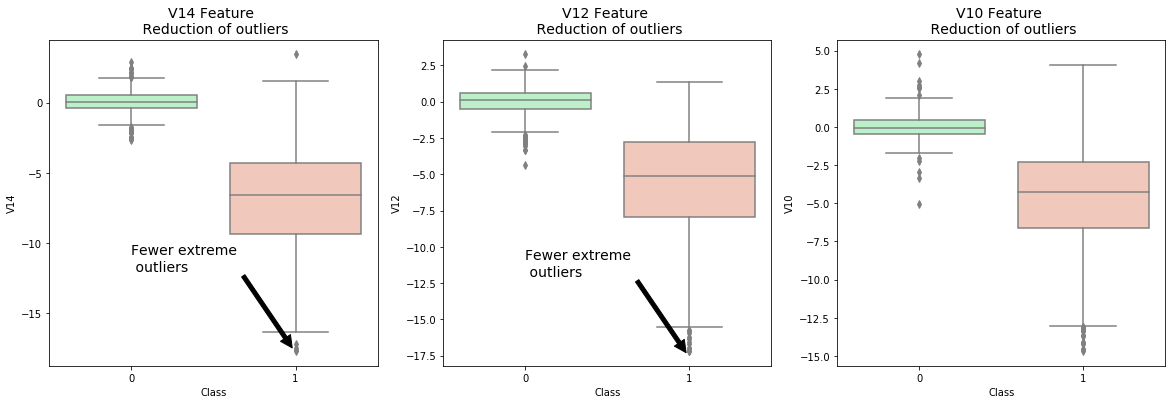

In [0]:
f,(ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,6))

colors = ['#B3F9C5', '#f9c5b3']
# Boxplots sau khi bỏ các giá trị ngoại vi
# Thuộc tính V14
sns.boxplot(x="Class", y="V14", data=new_df,ax=ax1, palette=colors)
ax1.set_title("V14 Feature \n Reduction of outliers", fontsize=14)
ax1.annotate('Fewer extreme \n outliers', xy=(0.98, -17.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

# Thuộc tính 12
sns.boxplot(x="Class", y="V12", data=new_df, ax=ax2, palette=colors)
ax2.set_title("V12 Feature \n Reduction of outliers", fontsize=14)
ax2.annotate('Fewer extreme \n outliers', xy=(0.98, -17.3), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

# Thuộc tính V10
sns.boxplot(x="Class", y="V10", data=new_df, ax=ax3, palette=colors)
ax3.set_title("V10 Feature \n Reduction of outliers", fontsize=14)
ax3.annotate('Fewer extreme \n outliers', xy=(0.95, -16.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)


plt.show()

**Tóm lược:**
- Trực quan hóa phân phối: Trước tiên chúng tôi bắt đầu bằng cách hình dung phân phối tính năng mà chúng tôi sẽ sử dụng để loại bỏ một số ngoại lệ.  V14 là tính năng duy nhất có phân phối Gaussian so với các tính năng V12 và V10.
- Xác định ngưỡng: Sau khi chúng tôi quyết định số nào, chúng tôi sẽ sử dụng để nhân với iqr (loại bỏ nhiều ngoại lệ hơn), chúng tôi sẽ tiến hành xác định ngưỡng trên và dưới bằng cách đặt ngưỡng q25 (ngưỡng cực thấp) và thêm ngưỡng q75 +  (ngưỡng cực cao).

##6.3Lưu tệp dữ liệu đã random underSampling

In [0]:
from google.colab import drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [0]:
# Dự liệu sau khi làm sạch bằng undersamping, dùng để train.
new_df.to_csv('/content/drive/My Drive/Colab Notebooks/Graduation Thesis/Data/data_credit_undersampling.csv')
print('=====DONE=====')

=====DONE=====


##6.4 Thuật toán Random forest và UnderSampling

In [0]:
X = new_df.drop('Class', axis=1)
y = new_df['Class']

# X = data_undersampling.drop('Class', axis=1)
# y = data_undersampling['Class']

In [0]:
print('Số  lượng giao dịch trên từng nhãn:\n', y.value_counts())

Số  lượng giao dịch trên từng nhãn:
 0    490
1    457
Name: Class, dtype: int64


In [0]:
# Tách dữ liệu thành train set và test set
# Chúng tôi sẽ sử dụng xác thực chéo trên tập huấn luyện để điều chỉnh các tham số, sau đó kiểm tra dữ liệu chưa xem
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, shuffle=True, stratify=y, random_state=42)

In [0]:
print('Số  lượng giao dịch trên từng nhãn trên dữ liệu huấn luyện:\n')
print(y_train.value_counts())
print('Số  lượng giao dịch trên từng nhãn trên dữ liệu kiểm thử:\n')
print(y_test.value_counts())

Số  lượng giao dịch trên từng nhãn trên dữ liệu huấn luyện:

0    343
1    319
Name: Class, dtype: int64
Số  lượng giao dịch trên từng nhãn trên dữ liệu kiểm thử:

0    147
1    138
Name: Class, dtype: int64


In [0]:
# Mô hình
model = RandomForestClassifier(n_estimators=50, n_jobs=-1, max_features='sqrt', random_state=42)

# Danh sách confusion matrix của từng lần KFold
conf_matrix_list_of_arrays = []
conf_matrix_list_of_arrays_test_set = []

# Danh sách độ chính xác của từng lần KFold trên dữ liệu test
accuracy_train_set = []
accuracy_test_set = []
f1_score_train = []
f1_score_test = []

# Cross Vallidation: KFold = 3
cv = StratifiedKFold(n_splits=3, random_state=None, shuffle=True)
cv.get_n_splits(X_train, y_train)

# List time train
times_train = []

for train_index, test_index in cv.split(X_train, y_train):
    undersample_Xtrain, undersample_Xtest = X_train.iloc[train_index], X_train.iloc[test_index]
    undersample_ytrain, undersample_ytest = y_train.iloc[train_index], y_train.iloc[test_index]

    # Thời gian bắt đầu train
    start_time = timer()

    model.fit(undersample_Xtrain, undersample_ytrain)
    y_pre_train = model.predict(undersample_Xtest)
    y_pre_test = model.predict(X_test)

    # Print the accuracy
    accuracy_train_set.append(
        accuracy_score(undersample_ytest, y_pre_train, normalize=True)*100)
    accuracy_test_set.append(
        accuracy_score(y_test, y_pre_test, normalize=True)*100)

    # Confusion matrix
    conf_matrix = confusion_matrix(undersample_ytest, y_pre_train)
    conf_matrix_list_of_arrays.append(conf_matrix)
    conf_matrix_2 = confusion_matrix(y_test, y_pre_test)
    conf_matrix_list_of_arrays_test_set.append(conf_matrix_2)

    # F1 score
    f1_score_train.append(f1_score(undersample_ytest, y_pre_train))
    f1_score_test.append(f1_score(y_test, y_pre_test))

    # Thời gian kết thúc train
    end_time = timer()
    # Tính thời gian thực hiện
    time_train = (end_time - start_time)
    times_train.append(time_train)

# Độ chính xác của mô hình
print('Độ chính xác của mô hình trên dữ liệu train: ', accuracy_train_set)
print('Độ chính xác của mô hình trên dữ liệu test: ', accuracy_test_set)

print('Độ chính xác trung bình dữ liệu train:', np.mean(accuracy_train_set))
print('Độ chính xác trung bình dữ liệu test:', np.mean(accuracy_test_set))

print('F1 score trung bình trên dữ liệu train:', np.mean(f1_score_train))
print('F1 score trung bình trên dữ liệu test:', np.mean(f1_score_test))

print('Thời gian thực hiện: ', times_train)

Độ chính xác của mô hình trên dữ liệu train:  [95.4954954954955, 94.54545454545455, 93.63636363636364]
Độ chính xác của mô hình trên dữ liệu test:  [93.33333333333333, 92.63157894736842, 93.6842105263158]
Độ chính xác trung bình dữ liệu train: 94.55910455910457
Độ chính xác trung bình dữ liệu test: 93.21637426900584
F1 score trung bình trên dữ liệu train: 0.9406033552073155
F1 score trung bình trên dữ liệu test: 0.9264021517236042
Thời gian thực hiện:  [0.44441751100021065, 0.44387483699938457, 0.43716579700048896]


Confusion matrix, without normalization
[[144   3]
 [ 16 121]]


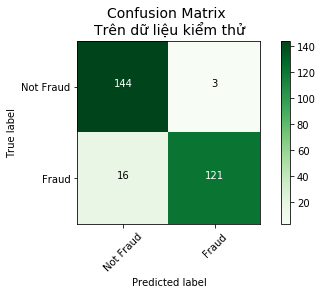

In [0]:
# Confusion matrix: dữ liệu test
actual_cm_test_set = np.mean(conf_matrix_list_of_arrays_test_set, axis=0).astype(int)
labels = ['Not Fraud', 'Fraud']
plot_confusion_matrix(actual_cm_test_set, labels, title="Confusion Matrix \nTrên dữ liệu kiểm thử", cmap=plt.cm.Greens)

###Kết quả

- Có 144 giao dịch không gian lận được dự đoán đúng là giao dịch không gian lận
- 3 lần giao dịch không gian lận được dự sai đoán là giao dịch gian lận
- 16 lần giao dịch gian lận được dự đoán sai là giao dịch không gian lận
- 121 lần giao dịch gian lận được dự đoán chính xác là giao dịch gian lận

##6.5 Thuật toán XGBoost và kỹ thuật UnderSampling

In [0]:
# Mô hình
model = XGBClassifier(objective="binary:logistic", random_state=42)

# Danh sách confusion matrix của từng lần KFold
conf_matrix_list_of_arrays = []
conf_matrix_list_of_arrays_test_set = []

# Danh sách độ chính xác của từng lần KFold trên dữ liệu test
accuracy_train_set = []
accuracy_test_set = []
f1_score_train = []
f1_score_test = []

# Cross Vallidation: KFold = 3
cv = StratifiedKFold(n_splits=3, random_state=None, shuffle=True)
cv.get_n_splits(X_train, y_train)

# List time train
times_train = []

for train_index, test_index in cv.split(X_train, y_train):
    undersample_Xtrain, undersample_Xtest = X_train.iloc[train_index], X_train.iloc[test_index]
    undersample_ytrain, undersample_ytest = y_train.iloc[train_index], y_train.iloc[test_index]

    # Thời gian bắt đầu train
    start_time = timer()

    model.fit(undersample_Xtrain, undersample_ytrain)
    y_pre_train = model.predict(undersample_Xtest)
    y_pre_test = model.predict(X_test)

    # Print the accuracy
    accuracy_train_set.append(
        accuracy_score(undersample_ytest, y_pre_train, normalize=True)*100)
    accuracy_test_set.append(
        accuracy_score(y_test, y_pre_test, normalize=True)*100)

    # Confusion matrix
    conf_matrix = confusion_matrix(undersample_ytest, y_pre_train)
    conf_matrix_list_of_arrays.append(conf_matrix)
    conf_matrix_2 = confusion_matrix(y_test, y_pre_test)
    conf_matrix_list_of_arrays_test_set.append(conf_matrix_2)

    # F1 score
    f1_score_train.append(f1_score(undersample_ytest, y_pre_train))
    f1_score_test.append(f1_score(y_test, y_pre_test))

    # Thời gian kết thúc train
    end_time = timer()
    # Tính thời gian thực hiện
    time_train = (end_time - start_time)
    times_train.append(time_train)

# Độ chính xác của mô hình
print('Độ chính xác của mô hình trên dữ liệu train: ', accuracy_train_set)
print('Độ chính xác của mô hình trên dữ liệu test: ', accuracy_test_set)

print('Độ chính xác trung bình dữ liệu train:', np.mean(accuracy_train_set))
print('Độ chính xác trung bình dữ liệu test:', np.mean(accuracy_test_set))

print('F1 score trung bình trên dữ liệu train:', np.mean(f1_score_train))
print('F1 score trung bình trên dữ liệu test:', np.mean(f1_score_test))

print('Thời gian thực hiện: ', times_train)

Độ chính xác của mô hình trên dữ liệu train:  [95.4954954954955, 94.0909090909091, 92.27272727272727]
Độ chính xác của mô hình trên dữ liệu test:  [91.9298245614035, 94.03508771929825, 92.28070175438596]
Độ chính xác trung bình dữ liệu train: 93.95304395304396
Độ chính xác trung bình dữ liệu test: 92.74853801169591
F1 score trung bình trên dữ liệu train: 0.9355507302485032
F1 score trung bình trên dữ liệu test: 0.9226852179011037
Thời gian thực hiện:  [0.12125093000031484, 0.10555891000149131, 0.10863392999999633]


Confusion matrix, without normalization
[[141   6]
 [ 14 123]]


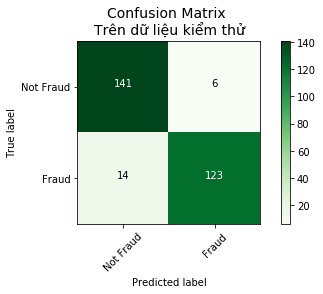

In [0]:
# Confusion matrix: dữ liệu test
actual_cm_test_set = np.mean(conf_matrix_list_of_arrays_test_set, axis=0).astype(int)
labels = ['Not Fraud', 'Fraud']
plot_confusion_matrix(actual_cm_test_set, labels, title="Confusion Matrix \nTrên dữ liệu kiểm thử", cmap=plt.cm.Greens)

###Kết quả

- Có 141 giao dịch không gian lận được dự đoán đúng là giao dịch không gian lận
- 6 lần giao dịch không gian lận được dự sai đoán là giao dịch gian lận
- 14 lần giao dịch gian lận được dự đoán sai là giao dịch không gian lận
- 123 lần giao dịch gian lận được dự đoán chính xác là giao dịch gian lận

#7.Kỹ thuật SMOTE (Over-Sampling):

SMOTE là viết tắt cuả Synthetic Minority Over-sampling Technique
- Không giống như Random UnderSampling, SMOTE tạo các điểm tổng hợp mới để có sự cân bằng của các lớp. Đây là một cách khác để giải quyết "các vấn đề mất cân bằng".

**Hiểu về SMOTE:**
- SMOTE tạo ra các dữ liệu tổng hợp(synthetic points) từ lớp thiểu số để đạt được sự cân bằng giữa nhóm thiểu số và đa số.
- Vị trí của các synthetic points: SMOTE chọn khoảng cách giữa các lân cận gần nhất của nhóm thiểu số, ở giữa các khoảng cách này, nó tạo ra các điểm tổng hợp.
- Nhiều thông tin được giữ lại vì chúng tôi không phải xóa bất kỳ hàng nào không giống như trong việc lấy mẫu ngẫu nhiên.
- Mặc dù có khả năng SMOTE sẽ chính xác hơn so với lấy mẫu ngẫu nhiên, nhưng sẽ mất nhiều thời gian hơn để đào tạo vì không có hàng nào bị loại bỏ như đã nêu trước đây.

In [0]:
X = data_raw.drop('Class', axis=1)
y = data_raw['Class']

In [0]:
print("Trước SMOTE, số lượng giao dịch gian lận là: {}".format(sum(y==1)))
print("Trước SMOTE, số lượng giao dịch không gian lận là: {} \n".format(sum(y==0)))

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_sample(X, y.ravel())

print('Sau SMOTE, Kích thước của dữ liệu train_X: {}'.format(X_res.shape))
print('Sau SMOTE, Kích thước của dữ liệu train_y: {} \n'.format(y_res.shape))

print("Sau SMOTE, Số lượng giao dịch gian lận là: {}".format(sum(y_res==1)))
print("Sau SMOTE, Số lượng giao dịch không gian lận là: {}".format(sum(y_res==0)))

Trước SMOTE, số lượng giao dịch gian lận là: 492
Trước SMOTE, số lượng giao dịch không gian lận là: 284315 

Sau SMOTE, Kích thước của dữ liệu train_X: (568630, 30)
Sau SMOTE, Kích thước của dữ liệu train_y: (568630,) 

Sau SMOTE, Số lượng giao dịch gian lận là: 284315
Sau SMOTE, Số lượng giao dịch không gian lận là: 284315


In [0]:
# Convert 'ndarray' to 'DataFrame'
X_res = pd.DataFrame(X_res, columns=X.columns)
y_res = pd.DataFrame(y_res, columns=['Class'])
print(X_train.shape)
print(y_train.shape)

(568630, 30)
(568630, 1)


In [0]:
data_smote = pd.concat([X_res, y_res], axis=1)

print(data_smote.shape)

(568630, 31)


##7.1 Ma trận tương quan

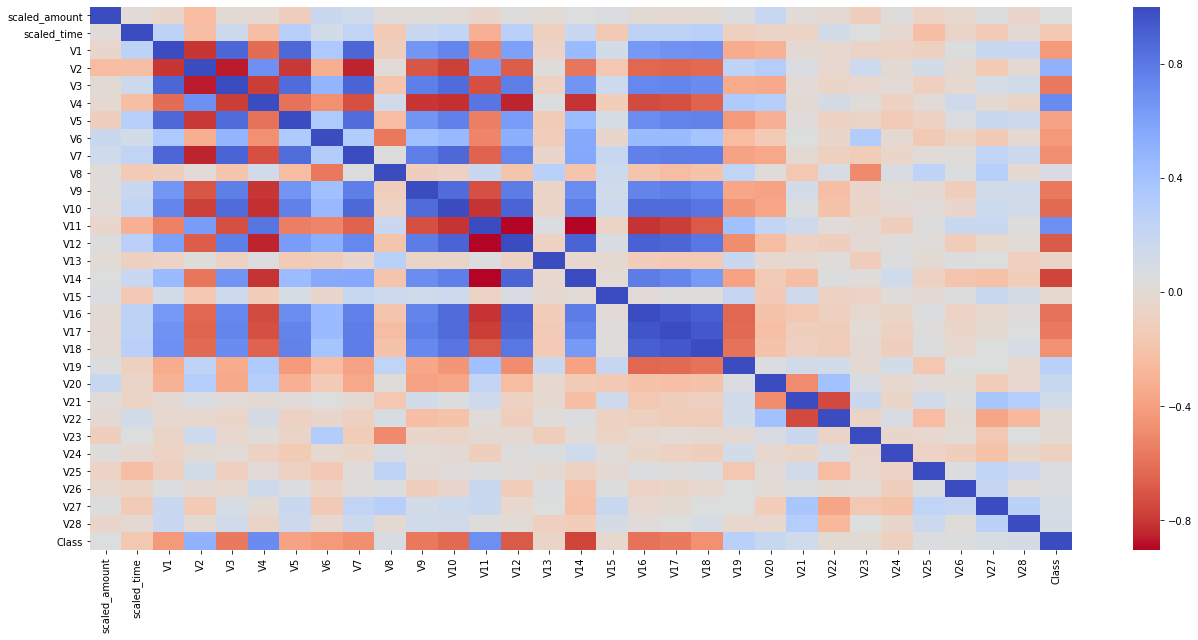

In [0]:
plt.figure(figsize=(22,10))
# Dữ bộ dữ liệu OverSampling
smote_corr = data_smote.corr()
ax = sns.heatmap(
    smote_corr, cmap='coolwarm_r', annot_kws={'size':20},
    xticklabels=corr.columns, yticklabels=corr.columns)
plt.show()

##7.2 Phát hiện bất thường (Anomaly Detection)


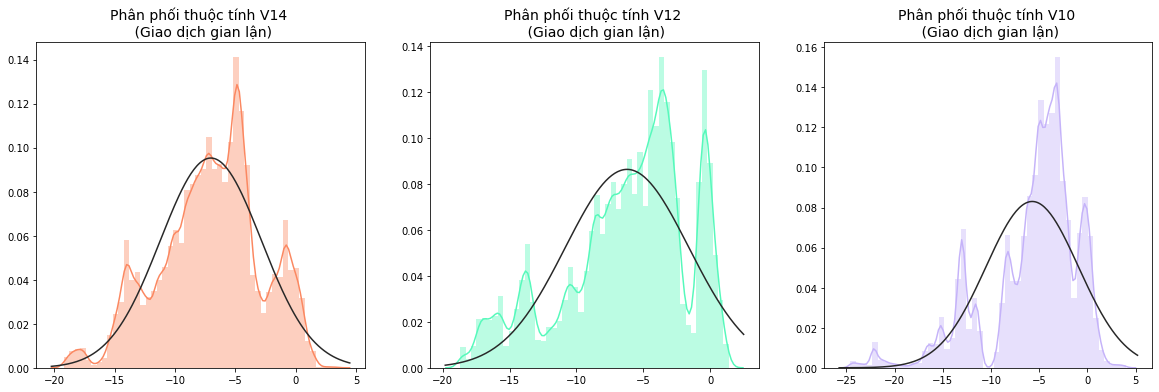

In [0]:
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 6))

v14_fraud_dist = data_smote['V14'].loc[data_smote['Class'] == 1].values
sns.distplot(v14_fraud_dist,ax=ax1, fit=norm, color='#FB8861')
ax1.set_title('Phân phối thuộc tính V14 \n (Giao dịch gian lận)', fontsize=14)

v12_fraud_dist = data_smote['V12'].loc[data_smote['Class'] == 1].values
sns.distplot(v12_fraud_dist,ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('Phân phối thuộc tính V12 \n (Giao dịch gian lận)', fontsize=14)


v10_fraud_dist = data_smote['V10'].loc[data_smote['Class'] == 1].values
sns.distplot(v10_fraud_dist,ax=ax3, fit=norm, color='#C5B3F9')
ax3.set_title('Phân phối thuộc tính V10 \n (Giao dịch gian lận)', fontsize=14)

plt.show()

In [0]:
v14_fraud_dist# # -----> V14 xóa giá trị ngoại vi khỏi các giao dịch gian lận
v14_fraud = data_smote['V14'].loc[data_smote['Class'] == 1].values
q25, q75 = np.percentile(v14_fraud, 25), np.percentile(v14_fraud, 75)
print('Bách phân bị 25: {} | Bách phân vị 75: {}'.format(q25, q75))
v14_iqr = q75 - q25
print('iqr: {}'.format(v14_iqr))

v14_cut_off = v14_iqr * 1.5
v14_lower, v14_upper = q25 - v14_cut_off, q75 + v14_cut_off
print('V14 Giá trị biên dưới: {}'.format(v14_lower))
print('V14 Giá trị biên trên: {}'.format(v14_upper))

outliers = [x for x in v14_fraud if x < v14_lower or x > v14_upper]
print('Tính năng V14 có số giá trị ngoại vi là: {}'.format(len(outliers)))

data_smote = data_smote.drop(data_smote[(data_smote['V14'] > v14_upper) | (data_smote['V14'] < v14_lower)].index)
print('Số lượng dữ liệu còn lại sau khi loại bỏ các giá trị ngoại vi: {}'.format(len(data_smote)))
print('----' * 44)

# -----> V12 xóa giá trị ngoại vi khỏi các giao dịch gian lận
v12_fraud = data_smote['V12'].loc[data_smote['Class'] == 1].values
q25, q75 = np.percentile(v12_fraud, 25), np.percentile(v12_fraud, 75)
v12_iqr = q75 - q25

v12_cut_off = v12_iqr * 1.5
v12_lower, v12_upper = q25 - v12_cut_off, q75 + v12_cut_off
print('V12 Giá trị biên dưới: {}'.format(v12_lower))
print('V12 Giá trị biên trên: {}'.format(v12_upper))
outliers = [x for x in v12_fraud if x < v12_lower or x > v12_upper]
print('Tính năng V12 có số giá trị ngoại vi là: {}'.format(len(outliers)))

data_smote = data_smote.drop(data_smote[(data_smote['V12'] > v12_upper) | (data_smote['V12'] < v12_lower)].index)
print('Số lượng dữ liệu còn lại sau khi loại bỏ các giá trị ngoại vi: {}'.format(len(data_smote)))
print('----' * 44)


# V10 xóa giá trị ngoại vi khỏi các giao dịch gian lận
v10_fraud = data_smote['V10'].loc[data_smote['Class'] == 1].values
q25, q75 = np.percentile(v10_fraud, 25), np.percentile(v10_fraud, 75)
v10_iqr = q75 - q25

v10_cut_off = v10_iqr * 1.5
v10_lower, v10_upper = q25 - v10_cut_off, q75 + v10_cut_off
print('V10 Giá trị biên dưới: {}'.format(v10_lower))
print('V10 Giá trị biên trên: {}'.format(v10_upper))
outliers = [x for x in v10_fraud if x < v10_lower or x > v10_upper]
print('Tính năng V10 có số giá trị ngoại vi là: {}'.format(len(outliers)))
data_smote = data_smote.drop(data_smote[(data_smote['V10'] > v10_upper) | (data_smote['V10'] < v10_lower)].index)
print('Số lượng dữ liệu còn lại sau khi loại bỏ các giá trị ngoại vi: {}'.format(len(data_smote)))

Bách phân bị 25: -9.695482028326186 | Bách phân vị 75: -4.415360735138973
iqr: 5.280121293187213
V14 Giá trị biên dưới: -17.615663968107004
V14 Giá trị biên trên: 3.5048212046418454
Tính năng V14 có số giá trị ngoại vi là: 3288
Số lượng dữ liệu còn lại sau khi loại bỏ các giá trị ngoại vi: 564955
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
V12 Giá trị biên dưới: -16.971251717745947
V12 Giá trị biên trên: 5.366915377829567
Tính năng V12 có số giá trị ngoại vi là: 3762
Số lượng dữ liệu còn lại sau khi loại bỏ các giá trị ngoại vi: 561193
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
V10 Giá trị biên dưới: -14.117994231594407
V10 Giá trị biên trên: 4.198416500881615
Tính năng V10 có số giá trị ngoại vi là: 17970
Số lượng dữ liệu 

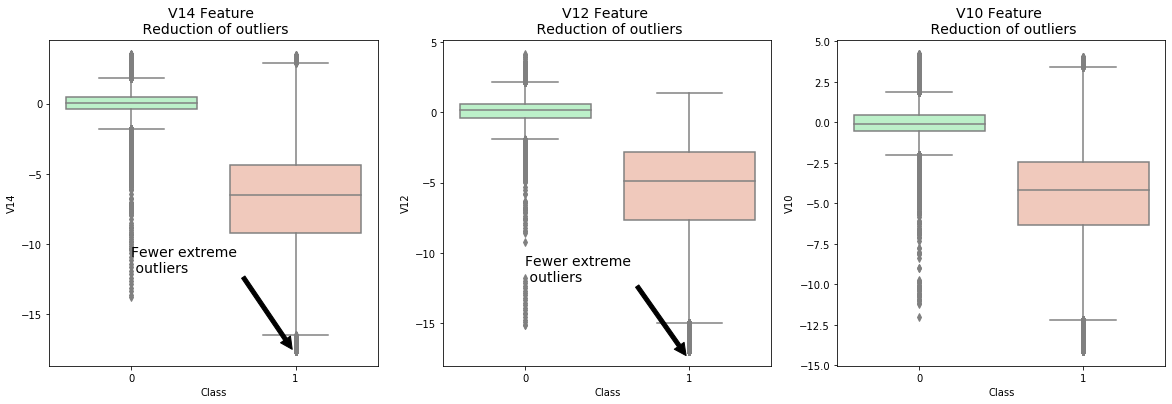

In [0]:
f,(ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,6))

colors = ['#B3F9C5', '#f9c5b3']
# Boxplots sau khi bỏ các giá trị ngoại vi
# Thuộc tính V14
sns.boxplot(x="Class", y="V14", data=data_smote,ax=ax1, palette=colors)
ax1.set_title("V14 Feature \n Reduction of outliers", fontsize=14)
ax1.annotate('Fewer extreme \n outliers', xy=(0.98, -17.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

# Thuộc tính 12
sns.boxplot(x="Class", y="V12", data=data_smote, ax=ax2, palette=colors)
ax2.set_title("V12 Feature \n Reduction of outliers", fontsize=14)
ax2.annotate('Fewer extreme \n outliers', xy=(0.98, -17.3), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

# Thuộc tính V10
sns.boxplot(x="Class", y="V10", data=data_smote, ax=ax3, palette=colors)
ax3.set_title("V10 Feature \n Reduction of outliers", fontsize=14)
ax3.annotate('Fewer extreme \n outliers', xy=(0.95, -16.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)


plt.show()

##7.3 Lưu tệp dữ liệu đã sử dụng kỹ thuật SMOTE

In [0]:
from google.colab import drive
drive.mount('drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at drive


In [0]:
# Dự liệu sau khi làm sạch bằng undersamping, dùng để train.
new_df.to_csv('/content/drive/My Drive/Colab Notebooks/Graduation Thesis/Data/data_credit_smote.csv')
print('=====DONE=====')

=====DONE=====


##7.4 Thuật toán Random forest và SMOTE

In [0]:
X = data_smote.drop('Class', axis=1)
y = data_smote['Class']

In [0]:
print('Số  lượng giao dịch trên từng nhãn:\n', y.value_counts())

Số  lượng giao dịch trên từng nhãn:
 0    282012
1    259295
Name: Class, dtype: int64


In [0]:
# Tách dữ liệu thành train set và test set
# Chúng tôi sẽ sử dụng xác thực chéo trên tập huấn luyện để điều chỉnh các tham số, sau đó kiểm tra dữ liệu chưa xem
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, shuffle=True, stratify=y, random_state=42)

In [0]:
print('Số  lượng giao dịch trên từng nhãn trên dữ liệu huấn luyện:\n')
print(y_train.value_counts())
print('Số  lượng giao dịch trên từng nhãn trên dữ liệu kiểm thử:\n')
print(y_test.value_counts())

Số  lượng giao dịch trên từng nhãn trên dữ liệu huấn luyện:

0    197408
1    181506
Name: Class, dtype: int64
Số  lượng giao dịch trên từng nhãn trên dữ liệu kiểm thử:

0    84604
1    77789
Name: Class, dtype: int64


In [0]:
# Mô hình
model = RandomForestClassifier(n_estimators=50, n_jobs=-1, max_features='sqrt', random_state=42)

# Danh sách confusion matrix của từng lần KFold
conf_matrix_list_of_arrays = []
conf_matrix_list_of_arrays_test_set = []

# Danh sách độ chính xác của từng lần KFold trên dữ liệu test
accuracy_train_set = []
accuracy_test_set = []
f1_score_train = []
f1_score_test = []

# Cross Vallidation: KFold = 3
cv = StratifiedKFold(n_splits=3, random_state=None, shuffle=True)
cv.get_n_splits(X_train, y_train)

# List time train
times_train = []

for train_index, test_index in cv.split(X_train, y_train):
    undersample_Xtrain, undersample_Xtest = X_train.iloc[train_index], X_train.iloc[test_index]
    undersample_ytrain, undersample_ytest = y_train.iloc[train_index], y_train.iloc[test_index]

    # Thời gian bắt đầu train
    start_time = timer()

    model.fit(undersample_Xtrain, undersample_ytrain)
    y_pre_train = model.predict(undersample_Xtest)
    y_pre_test = model.predict(X_test)

    # Print the accuracy
    accuracy_train_set.append(
        accuracy_score(undersample_ytest, y_pre_train, normalize=True)*100)
    accuracy_test_set.append(
        accuracy_score(y_test, y_pre_test, normalize=True)*100)

    # Confusion matrix
    conf_matrix = confusion_matrix(undersample_ytest, y_pre_train)
    conf_matrix_list_of_arrays.append(conf_matrix)
    conf_matrix_2 = confusion_matrix(y_test, y_pre_test)
    conf_matrix_list_of_arrays_test_set.append(conf_matrix_2)

    # F1 score
    f1_score_train.append(f1_score(undersample_ytest, y_pre_train))
    f1_score_test.append(f1_score(y_test, y_pre_test))

    # Thời gian kết thúc train
    end_time = timer()
    # Tính thời gian thực hiện
    time_train = (end_time - start_time)
    times_train.append(time_train)

# Độ chính xác của mô hình
print('Độ chính xác của mô hình trên dữ liệu train: ', accuracy_train_set)
print('Độ chính xác của mô hình trên dữ liệu test: ', accuracy_test_set)

print('Độ chính xác trung bình dữ liệu train:', np.mean(accuracy_train_set))
print('Độ chính xác trung bình dữ liệu test:', np.mean(accuracy_test_set))

print('F1 score trung bình trên dữ liệu train:', np.mean(f1_score_train))
print('F1 score trung bình trên dữ liệu test:', np.mean(f1_score_test))

print('Thời gian thực hiện: ', times_train)

Độ chính xác của mô hình trên dữ liệu train:  [99.9889157198844, 99.98179011123867, 99.98258170762605]
Độ chính xác của mô hình trên dữ liệu test:  [99.97721576668945, 99.97721576668945, 99.98029471713681]
Độ chính xác trung bình dữ liệu train: 99.98442917958305
Độ chính xác trung bình dữ liệu test: 99.97824208350524
F1 score trung bình trên dữ liệu train: 0.9998374953613659
F1 score trung bình trên dữ liệu test: 0.9997729227656541
Thời gian thực hiện:  [67.83406516300238, 67.80822561199966, 67.40445783500036]


Confusion matrix, without normalization
[[84575    29]
 [    6 77782]]


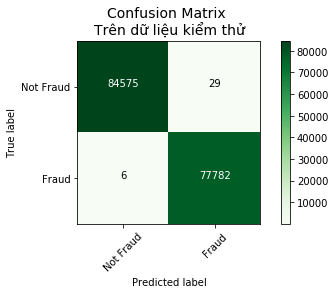

In [0]:
# Confusion matrix: dữ liệu test
actual_cm_test_set = np.mean(conf_matrix_list_of_arrays_test_set, axis=0).astype(int)
labels = ['Not Fraud', 'Fraud']
plot_confusion_matrix(actual_cm_test_set, labels, title="Confusion Matrix \nTrên dữ liệu kiểm thử", cmap=plt.cm.Greens)

###Kết quả

- Có 84575 giao dịch không gian lận được dự đoán đúng là giao dịch không gian lận
- 29 lần giao dịch không gian lận được dự sai đoán là giao dịch gian lận
- 6 lần giao dịch gian lận được dự đoán sai là giao dịch không gian lận
- 77782 lần giao dịch gian lận được dự đoán chính xác là giao dịch gian lận

##7.5 Thuật toán XGBoost và SMOTE

In [0]:
# Mô hình
model = XGBClassifier(objective="binary:logistic", random_state=42)

# Danh sách confusion matrix của từng lần KFold
conf_matrix_list_of_arrays = []
conf_matrix_list_of_arrays_test_set = []

# Danh sách độ chính xác của từng lần KFold trên dữ liệu test
accuracy_train_set = []
accuracy_test_set = []
f1_score_train = []
f1_score_test = []

# Cross Vallidation: KFold = 3
cv = StratifiedKFold(n_splits=3, random_state=None, shuffle=True)
cv.get_n_splits(X_train, y_train)

# List time train
times_train = []

for train_index, test_index in cv.split(X_train, y_train):
    undersample_Xtrain, undersample_Xtest = X_train.iloc[train_index], X_train.iloc[test_index]
    undersample_ytrain, undersample_ytest = y_train.iloc[train_index], y_train.iloc[test_index]

    # Thời gian bắt đầu train
    start_time = timer()

    model.fit(undersample_Xtrain, undersample_ytrain)
    y_pre_train = model.predict(undersample_Xtest)
    y_pre_test = model.predict(X_test)

    # Print the accuracy
    accuracy_train_set.append(
        accuracy_score(undersample_ytest, y_pre_train, normalize=True)*100)
    accuracy_test_set.append(
        accuracy_score(y_test, y_pre_test, normalize=True)*100)

    # Confusion matrix
    conf_matrix = confusion_matrix(undersample_ytest, y_pre_train)
    conf_matrix_list_of_arrays.append(conf_matrix)
    conf_matrix_2 = confusion_matrix(y_test, y_pre_test)
    conf_matrix_list_of_arrays_test_set.append(conf_matrix_2)

    # F1 score
    f1_score_train.append(f1_score(undersample_ytest, y_pre_train))
    f1_score_test.append(f1_score(y_test, y_pre_test))

    # Thời gian kết thúc train
    end_time = timer()
    # Tính thời gian thực hiện
    time_train = (end_time - start_time)
    times_train.append(time_train)

# Độ chính xác của mô hình
print('Độ chính xác của mô hình trên dữ liệu train: ', accuracy_train_set)
print('Độ chính xác của mô hình trên dữ liệu test: ', accuracy_test_set)

print('Độ chính xác trung bình dữ liệu train:', np.mean(accuracy_train_set))
print('Độ chính xác trung bình dữ liệu test:', np.mean(accuracy_test_set))

print('F1 score trung bình trên dữ liệu train:', np.mean(f1_score_train))
print('F1 score trung bình trên dữ liệu test:', np.mean(f1_score_test))

print('Thời gian thực hiện: ', times_train)

Độ chính xác của mô hình trên dữ liệu train:  [97.70634575036617, 97.61767150944142, 97.62794527489233]
Độ chính xác của mô hình trên dữ liệu test:  [97.5873344294397, 97.50358697727118, 97.60580813212391]
Độ chính xác trung bình dữ liệu train: 97.65065417823331
Độ chính xác trung bình dữ liệu test: 97.56557651294493
F1 score trung bình trên dữ liệu train: 0.9751751409015968
F1 score trung bình trên dữ liệu test: 0.9742672713378265
Thời gian thực hiện:  [70.53255674799948, 70.58004456499839, 70.54269218699847]


Confusion matrix, without normalization
[[83601  1003]
 [ 2950 74838]]


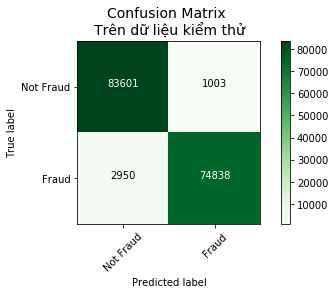

In [0]:
# Confusion matrix: dữ liệu test
actual_cm_test_set = np.mean(conf_matrix_list_of_arrays_test_set, axis=0).astype(int)
labels = ['Not Fraud', 'Fraud']
plot_confusion_matrix(actual_cm_test_set, labels, title="Confusion Matrix \nTrên dữ liệu kiểm thử", cmap=plt.cm.Greens)

###Kết quả

- Có 83601 giao dịch không gian lận được dự đoán đúng là giao dịch không gian lận
- 1003 lần giao dịch không gian lận được dự sai đoán là giao dịch gian lận
- 2950 lần giao dịch gian lận được dự đoán sai là giao dịch không gian lận
- 74838 lần giao dịch gian lận được dự đoán chính xác là giao dịch gian lận

#8.Dữ liệu thuần

In [0]:
X = data_raw.drop('Class', axis=1)
y = data_raw['Class']

In [0]:
print('Số  lượng giao dịch trên từng nhãn:\n', y.value_counts())

Số  lượng giao dịch trên từng nhãn:
 0    284315
1       492
Name: Class, dtype: int64


In [0]:
# Tách dữ liệu thành train set và test set
# Chúng tôi sẽ sử dụng xác thực chéo trên tập huấn luyện để điều chỉnh các tham số, sau đó kiểm tra dữ liệu chưa xem
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, shuffle=True, stratify=y, random_state=42)

In [0]:
print('Số  lượng giao dịch trên từng nhãn trên dữ liệu huấn luyện:\n')
print(y_train.value_counts())
print('Số  lượng giao dịch trên từng nhãn trên dữ liệu kiểm thử:\n')
print(y_test.value_counts())

Số  lượng giao dịch trên từng nhãn trên dữ liệu huấn luyện:

0    199020
1       344
Name: Class, dtype: int64
Số  lượng giao dịch trên từng nhãn trên dữ liệu kiểm thử:

0    85295
1      148
Name: Class, dtype: int64


##8.1 Thuật toán Random Forest và dữ liệu thuần

In [0]:
# Mô hình
model = RandomForestClassifier(n_estimators=50, n_jobs=-1, max_features='sqrt', random_state=42)

# Danh sách confusion matrix của từng lần KFold
conf_matrix_list_of_arrays = []
conf_matrix_list_of_arrays_test_set = []

# Danh sách độ chính xác của từng lần KFold trên dữ liệu test
accuracy_train_set = []
accuracy_test_set = []
f1_score_train = []
f1_score_test = []

# Cross Vallidation: KFold = 3
cv = StratifiedKFold(n_splits=3, random_state=None, shuffle=True)
cv.get_n_splits(X_train, y_train)

# List time train
times_train = []

for train_index, test_index in cv.split(X_train, y_train):
    undersample_Xtrain, undersample_Xtest = X_train.iloc[train_index], X_train.iloc[test_index]
    undersample_ytrain, undersample_ytest = y_train.iloc[train_index], y_train.iloc[test_index]

    # Thời gian bắt đầu train
    start_time = timer()

    model.fit(undersample_Xtrain, undersample_ytrain)
    y_pre_train = model.predict(undersample_Xtest)
    y_pre_test = model.predict(X_test)

    # Print the accuracy
    accuracy_train_set.append(
        accuracy_score(undersample_ytest, y_pre_train, normalize=True)*100)
    accuracy_test_set.append(
        accuracy_score(y_test, y_pre_test, normalize=True)*100)

    # Confusion matrix
    conf_matrix = confusion_matrix(undersample_ytest, y_pre_train)
    conf_matrix_list_of_arrays.append(conf_matrix)
    conf_matrix_2 = confusion_matrix(y_test, y_pre_test)
    conf_matrix_list_of_arrays_test_set.append(conf_matrix_2)

    # F1 score
    f1_score_train.append(f1_score(undersample_ytest, y_pre_train))
    f1_score_test.append(f1_score(y_test, y_pre_test))

    # Thời gian kết thúc train
    end_time = timer()
    # Tính thời gian thực hiện
    time_train = (end_time - start_time)
    times_train.append(time_train)

# Độ chính xác của mô hình
print('Độ chính xác của mô hình trên dữ liệu train: ', accuracy_train_set)
print('Độ chính xác của mô hình trên dữ liệu test: ', accuracy_test_set)

print('Độ chính xác trung bình dữ liệu train:', np.mean(accuracy_train_set))
print('Độ chính xác trung bình dữ liệu test:', np.mean(accuracy_test_set))

print('F1 score trung bình trên dữ liệu train:', np.mean(f1_score_train))
print('F1 score trung bình trên dữ liệu test:', np.mean(f1_score_test))

print('Thời gian thực hiện: ', times_train)

Độ chính xác của mô hình trên dữ liệu train:  [99.93980889323602, 99.95636144759612, 99.95636079092304]
Độ chính xác của mô hình trên dữ liệu test:  [99.95786664794073, 99.95786664794073, 99.95786664794073]
Độ chính xác trung bình dữ liệu train: 99.95084371058506
Độ chính xác trung bình dữ liệu test: 99.95786664794075
F1 score trung bình trên dữ liệu train: 0.8425749431574561
F1 score trung bình trên dữ liệu test: 0.868911827060091
Thời gian thực hiện:  [35.807225071002904, 36.31799669100292, 36.902053441001044]


Confusion matrix, without normalization
[[85287     7]
 [   28   119]]


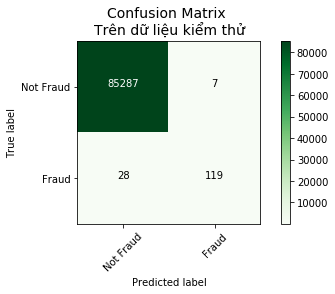

In [0]:
# Confusion matrix: dữ liệu test
actual_cm_test_set = np.mean(conf_matrix_list_of_arrays_test_set, axis=0).astype(int)
labels = ['Not Fraud', 'Fraud']
plot_confusion_matrix(actual_cm_test_set, labels, title="Confusion Matrix \nTrên dữ liệu kiểm thử", cmap=plt.cm.Greens)

###Kết quả

- Có 85287 giao dịch không gian lận được dự đoán đúng là giao dịch không gian lận
- 7 lần giao dịch không gian lận được dự sai đoán là giao dịch gian lận
- 28 lần giao dịch gian lận được dự đoán sai là giao dịch không gian lận
- 119 lần giao dịch gian lận được dự đoán chính xác là giao dịch gian lận

##8.2 Thuật toán XGBoost và dữ liệu thuần

In [0]:
# Mô hình
model = XGBClassifier(objective="binary:logistic", random_state=42)

# Danh sách confusion matrix của từng lần KFold
conf_matrix_list_of_arrays = []
conf_matrix_list_of_arrays_test_set = []

# Danh sách độ chính xác của từng lần KFold trên dữ liệu test
accuracy_train_set = []
accuracy_test_set = []
f1_score_train = []
f1_score_test = []

# Cross Vallidation: KFold = 3
cv = StratifiedKFold(n_splits=3, random_state=None, shuffle=True)
cv.get_n_splits(X_train, y_train)

# List time train
times_train = []

for train_index, test_index in cv.split(X_train, y_train):
    undersample_Xtrain, undersample_Xtest = X_train.iloc[train_index], X_train.iloc[test_index]
    undersample_ytrain, undersample_ytest = y_train.iloc[train_index], y_train.iloc[test_index]

    # Thời gian bắt đầu train
    start_time = timer()

    model.fit(undersample_Xtrain, undersample_ytrain)
    y_pre_train = model.predict(undersample_Xtest)
    y_pre_test = model.predict(X_test)

    # Print the accuracy
    accuracy_train_set.append(
        accuracy_score(undersample_ytest, y_pre_train, normalize=True)*100)
    accuracy_test_set.append(
        accuracy_score(y_test, y_pre_test, normalize=True)*100)

    # Confusion matrix
    conf_matrix = confusion_matrix(undersample_ytest, y_pre_train)
    conf_matrix_list_of_arrays.append(conf_matrix)
    conf_matrix_2 = confusion_matrix(y_test, y_pre_test)
    conf_matrix_list_of_arrays_test_set.append(conf_matrix_2)

    # F1 score
    f1_score_train.append(f1_score(undersample_ytest, y_pre_train))
    f1_score_test.append(f1_score(y_test, y_pre_test))

    # Thời gian kết thúc train
    end_time = timer()
    # Tính thời gian thực hiện
    time_train = (end_time - start_time)
    times_train.append(time_train)

# Độ chính xác của mô hình
print('Độ chính xác của mô hình trên dữ liệu train: ', accuracy_train_set)
print('Độ chính xác của mô hình trên dữ liệu test: ', accuracy_test_set)

print('Độ chính xác trung bình dữ liệu train:', np.mean(accuracy_train_set))
print('Độ chính xác trung bình dữ liệu test:', np.mean(accuracy_test_set))

print('F1 score trung bình trên dữ liệu train:', np.mean(f1_score_train))
print('F1 score trung bình trên dữ liệu test:', np.mean(f1_score_test))

print('Thời gian thực hiện: ', times_train)

Độ chính xác của mô hình trên dữ liệu train:  [99.95485666992701, 99.95034233691972, 99.94281758810605]
Độ chính xác của mô hình trên dữ liệu test:  [99.95084442259751, 99.9531851643786, 99.95084442259751]
Độ chính xác trung bình dữ liệu train: 99.94933886498426
Độ chính xác trung bình dữ liệu test: 99.95162466985788
F1 score trung bình trên dữ liệu train: 0.8396983230518238
F1 score trung bình trên dữ liệu test: 0.8509103641456582
Thời gian thực hiện:  [34.71860001200184, 34.82233598699895, 34.705028287997266]


Confusion matrix, without normalization
[[85283    11]
 [   30   118]]


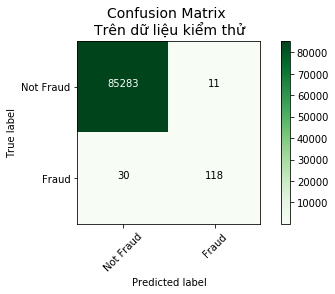

In [0]:
# Confusion matrix: dữ liệu test
actual_cm_test_set = np.mean(conf_matrix_list_of_arrays_test_set, axis=0).astype(int)
labels = ['Not Fraud', 'Fraud']
plot_confusion_matrix(actual_cm_test_set, labels, title="Confusion Matrix \nTrên dữ liệu kiểm thử", cmap=plt.cm.Greens)

###Kết quả

- Có 85283 giao dịch không gian lận được dự đoán đúng là giao dịch không gian lận
- 11 lần giao dịch không gian lận được dự sai đoán là giao dịch gian lận
- 30 lần giao dịch gian lận được dự đoán sai là giao dịch không gian lận
- 118 lần giao dịch gian lận được dự đoán chính xác là giao dịch gian lận

#9.Dữ liệu với SMOTE + ENN

In [0]:
X = data_raw.drop('Class', axis=1)
y = data_raw['Class']

In [0]:
print("Trước SMOTE + ENN, số lượng giao dịch gian lận là: {}".format(sum(y==1)))
print("Trước SMOTE + ENN, số lượng giao dịch không gian lận là: {} \n".format(sum(y==0)))

sm = SMOTEENN(random_state=42)
X_res, y_res = sm.fit_sample(X, y.ravel())

print('Sau SMOTE + ENN, Kích thước của dữ liệu train_X: {}'.format(X_res.shape))
print('Sau SMOTE + ENN, Kích thước của dữ liệu train_y: {} \n'.format(y_res.shape))

print("Sau SMOTE + ENN, Số lượng giao dịch gian lận là: {}".format(sum(y_res==1)))
print("Sau SMOTE + ENN, Số lượng giao dịch không gian lận là: {}".format(sum(y_res==0)))

Trước SMOTE + ENN, số lượng giao dịch gian lận là: 492
Trước SMOTE + ENN, số lượng giao dịch không gian lận là: 284315 

Sau SMOTE + ENN, Kích thước của dữ liệu train_X: (541135, 30)
Sau SMOTE + ENN, Kích thước của dữ liệu train_y: (541135,) 

Sau SMOTE + ENN, Số lượng giao dịch gian lận là: 275740
Sau SMOTE + ENN, Số lượng giao dịch không gian lận là: 265395


In [0]:
# Convert 'ndarray' to 'DataFrame'
X_res = pd.DataFrame(X_res, columns=X.columns)
y_res = pd.DataFrame(y_res, columns=['Class'])
print(X_res.shape)
print(y_res.shape)

(541135, 30)
(541135, 1)


In [0]:
data_smote_enn = pd.concat([X_res, y_res], axis=1)

print(data_smote_enn.shape)

(541135, 31)


##9.1 Ma trận tương quan

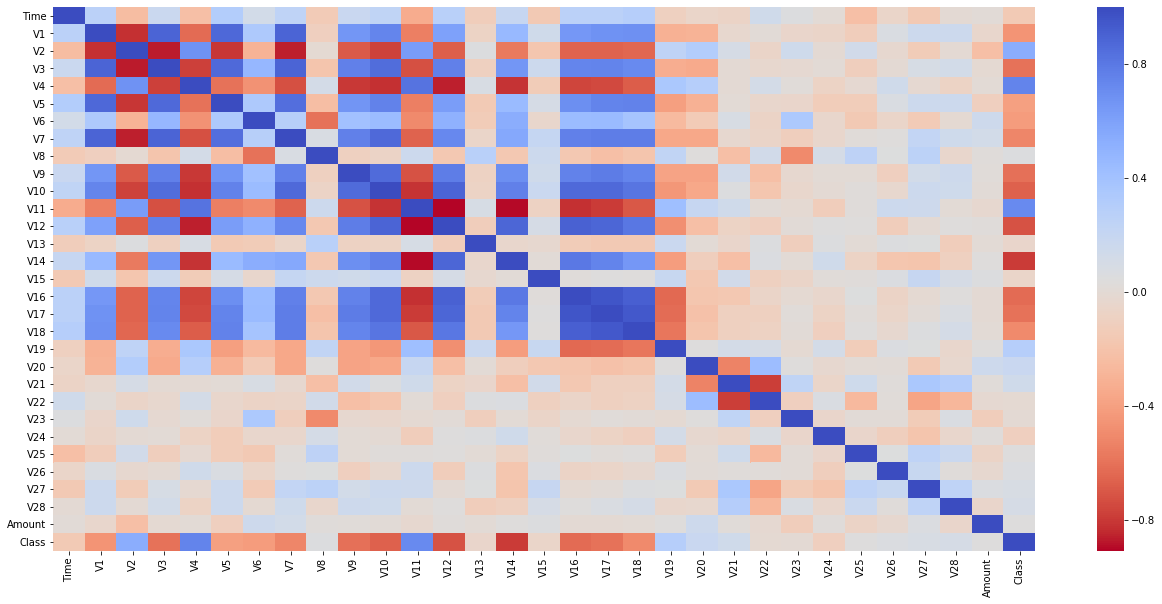

In [0]:
plt.figure(figsize=(22,10))
# Dữ bộ dữ liệu OverSampling
smote_enn_corr = data_smote_enn.corr()
ax = sns.heatmap(
    smote_enn_corr, cmap='coolwarm_r', annot_kws={'size':20},
    xticklabels=smote_enn_corr.columns, yticklabels=smote_enn_corr.columns)
plt.show()

##9.2 Phát hiện bất thường (Anomaly Detection)


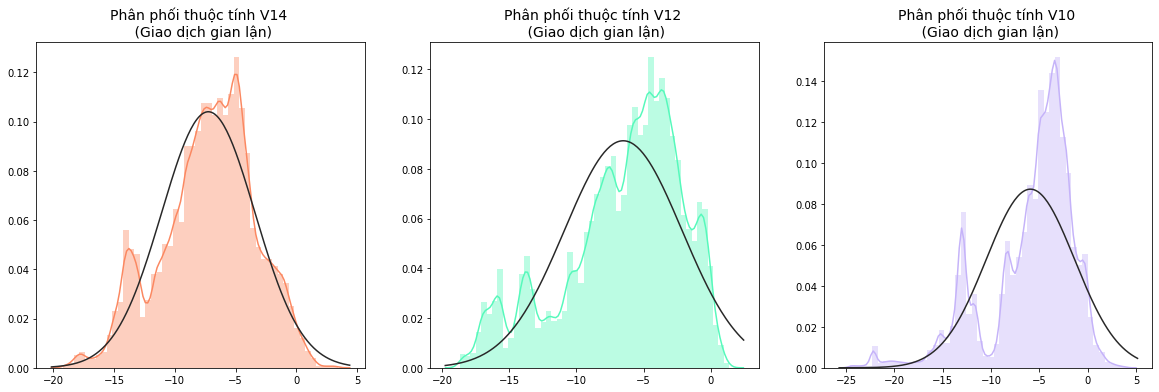

In [0]:
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 6))

v14_fraud_dist = data_smote_enn['V14'].loc[data_smote_enn['Class'] == 1].values
sns.distplot(v14_fraud_dist,ax=ax1, fit=norm, color='#FB8861')
ax1.set_title('Phân phối thuộc tính V14 \n (Giao dịch gian lận)', fontsize=14)

v12_fraud_dist = data_smote_enn['V12'].loc[data_smote_enn['Class'] == 1].values
sns.distplot(v12_fraud_dist,ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('Phân phối thuộc tính V12 \n (Giao dịch gian lận)', fontsize=14)


v10_fraud_dist = data_smote_enn['V10'].loc[data_smote_enn['Class'] == 1].values
sns.distplot(v10_fraud_dist,ax=ax3, fit=norm, color='#C5B3F9')
ax3.set_title('Phân phối thuộc tính V10 \n (Giao dịch gian lận)', fontsize=14)

plt.show()

In [0]:
v14_fraud_dist# # -----> V14 xóa giá trị ngoại vi khỏi các giao dịch gian lận
v14_fraud = data_smote_enn['V14'].loc[data_smote_enn['Class'] == 1].values
q25, q75 = np.percentile(v14_fraud, 25), np.percentile(v14_fraud, 75)
print('Bách phân bị 25: {} | Bách phân vị 75: {}'.format(q25, q75))
v14_iqr = q75 - q25
print('iqr: {}'.format(v14_iqr))

v14_cut_off = v14_iqr * 1.5
v14_lower, v14_upper = q25 - v14_cut_off, q75 + v14_cut_off
print('V14 Giá trị biên dưới: {}'.format(v14_lower))
print('V14 Giá trị biên trên: {}'.format(v14_upper))

outliers = [x for x in v14_fraud if x < v14_lower or x > v14_upper]
print('Tính năng V14 có số giá trị ngoại vi là: {}'.format(len(outliers)))

data_smote_enn = data_smote_enn.drop(data_smote_enn[(data_smote_enn['V14'] > v14_upper) | (data_smote_enn['V14'] < v14_lower)].index)
print('Số lượng dữ liệu còn lại sau khi loại bỏ các giá trị ngoại vi: {}'.format(len(data_smote_enn)))
print('----' * 44)

# -----> V12 xóa giá trị ngoại vi khỏi các giao dịch gian lận
v12_fraud = data_smote_enn['V12'].loc[data_smote_enn['Class'] == 1].values
q25, q75 = np.percentile(v12_fraud, 25), np.percentile(v12_fraud, 75)
v12_iqr = q75 - q25

v12_cut_off = v12_iqr * 1.5
v12_lower, v12_upper = q25 - v12_cut_off, q75 + v12_cut_off
print('V12 Giá trị biên dưới: {}'.format(v12_lower))
print('V12 Giá trị biên trên: {}'.format(v12_upper))
outliers = [x for x in v12_fraud if x < v12_lower or x > v12_upper]
print('Tính năng V12 có số giá trị ngoại vi là: {}'.format(len(outliers)))

data_smote_enn = data_smote_enn.drop(data_smote_enn[(data_smote_enn['V12'] > v12_upper) | (data_smote_enn['V12'] < v12_lower)].index)
print('Số lượng dữ liệu còn lại sau khi loại bỏ các giá trị ngoại vi: {}'.format(len(data_smote_enn)))
print('----' * 44)


# V10 xóa giá trị ngoại vi khỏi các giao dịch gian lận
v10_fraud = data_smote_enn['V10'].loc[data_smote_enn['Class'] == 1].values
q25, q75 = np.percentile(v10_fraud, 25), np.percentile(v10_fraud, 75)
v10_iqr = q75 - q25

v10_cut_off = v10_iqr * 1.5
v10_lower, v10_upper = q25 - v10_cut_off, q75 + v10_cut_off
print('V10 Giá trị biên dưới: {}'.format(v10_lower))
print('V10 Giá trị biên trên: {}'.format(v10_upper))
outliers = [x for x in v10_fraud if x < v10_lower or x > v10_upper]
print('Tính năng V10 có số giá trị ngoại vi là: {}'.format(len(outliers)))
data_smote_enn = data_smote_enn.drop(data_smote_enn[(data_smote_enn['V10'] > v10_upper) | (data_smote_enn['V10'] < v10_lower)].index)
print('Số lượng dữ liệu còn lại sau khi loại bỏ các giá trị ngoại vi: {}'.format(len(data_smote_enn)))

Bách phân bị 25: -9.590570615806337 | Bách phân vị 75: -4.663063330445958
iqr: 4.927507285360379
V14 Giá trị biên dưới: -16.981831543846905
V14 Giá trị biên trên: 2.728197597594611
Tính năng V14 có số giá trị ngoại vi là: 2411
Số lượng dữ liệu còn lại sau khi loại bỏ các giá trị ngoại vi: 537886
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
V12 Giá trị biên dưới: -16.770043654691314
V12 Giá trị biên trên: 4.755414024858468
Tính năng V12 có số giá trị ngoại vi là: 4326
Số lượng dữ liệu còn lại sau khi loại bỏ các giá trị ngoại vi: 533560
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
V10 Giá trị biên dưới: -14.52793065497507
V10 Giá trị biên trên: 4.149590359668818
Tính năng V10 có số giá trị ngoại vi là: 13545
Số lượng dữ liệu cò

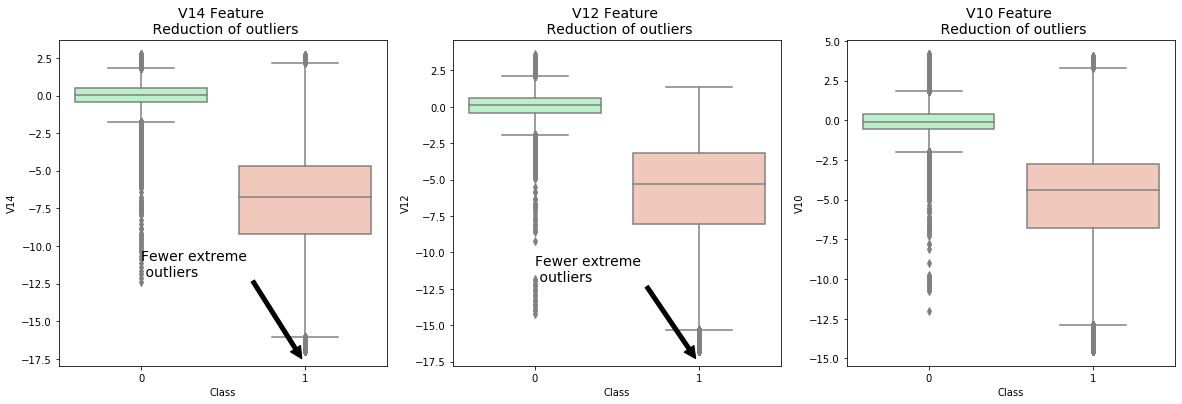

In [0]:
f,(ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,6))

colors = ['#B3F9C5', '#f9c5b3']
# Boxplots sau khi bỏ các giá trị ngoại vi
# Thuộc tính V14
sns.boxplot(x="Class", y="V14", data=data_smote_enn,ax=ax1, palette=colors)
ax1.set_title("V14 Feature \n Reduction of outliers", fontsize=14)
ax1.annotate('Fewer extreme \n outliers', xy=(0.98, -17.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

# Thuộc tính 12
sns.boxplot(x="Class", y="V12", data=data_smote_enn, ax=ax2, palette=colors)
ax2.set_title("V12 Feature \n Reduction of outliers", fontsize=14)
ax2.annotate('Fewer extreme \n outliers', xy=(0.98, -17.3), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

# Thuộc tính V10
sns.boxplot(x="Class", y="V10", data=data_smote_enn, ax=ax3, palette=colors)
ax3.set_title("V10 Feature \n Reduction of outliers", fontsize=14)
ax3.annotate('Fewer extreme \n outliers', xy=(0.95, -16.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)


plt.show()

##9.3 Lưu tệp dữ liệu đã sử dụng kỹ thuật SMOTE

In [0]:
from google.colab import drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [0]:
# Dự liệu sau khi làm sạch bằng undersamping, dùng để train.
data_smote_enn.to_csv('/content/drive/My Drive/Colab Notebooks/Graduation Thesis/Data/data_credit_smote_enn.csv')
print('=====DONE=====')

=====DONE=====


##9.4 Thuật toán Random Forest và SMOTE + ENN

In [0]:
X = data_smote_enn.drop('Class', axis=1)
y = data_smote_enn['Class']

In [0]:
print('Số  lượng giao dịch trên từng nhãn:\n', y.value_counts())

Số  lượng giao dịch trên từng nhãn:
 0    262695
1    255458
Name: Class, dtype: int64


In [0]:
# Tách dữ liệu thành train set và test set
# Chúng tôi sẽ sử dụng xác thực chéo trên tập huấn luyện để điều chỉnh các tham số, sau đó kiểm tra dữ liệu chưa xem
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, shuffle=True, stratify=y, random_state=42)

In [0]:
print('Số  lượng giao dịch trên từng nhãn trên dữ liệu huấn luyện:\n')
print(y_train.value_counts())
print('Số  lượng giao dịch trên từng nhãn trên dữ liệu kiểm thử:\n')
print(y_test.value_counts())

Số  lượng giao dịch trên từng nhãn trên dữ liệu huấn luyện:

0    183886
1    178821
Name: Class, dtype: int64
Số  lượng giao dịch trên từng nhãn trên dữ liệu kiểm thử:

0    78809
1    76637
Name: Class, dtype: int64


In [0]:
# Mô hình
model = RandomForestClassifier(n_estimators=50, n_jobs=-1, max_features='sqrt', random_state=42)

# Danh sách confusion matrix của từng lần KFold
conf_matrix_list_of_arrays = []
conf_matrix_list_of_arrays_test_set = []

# Danh sách độ chính xác của từng lần KFold trên dữ liệu test
accuracy_train_set = []
accuracy_test_set = []
f1_score_train = []
f1_score_test = []

# Cross Vallidation: KFold = 3
cv = StratifiedKFold(n_splits=3, random_state=None, shuffle=True)
cv.get_n_splits(X_train, y_train)

# List time train
times_train = []

for train_index, test_index in cv.split(X_train, y_train):
    smote_enn_Xtrain, smote_enn_Xtest = X_train.iloc[train_index], X_train.iloc[test_index]
    smote_enn_ytrain, smote_enn_ytest = y_train.iloc[train_index], y_train.iloc[test_index]

    # Thời gian bắt đầu train
    start_time = timer()

    model.fit(smote_enn_Xtrain, smote_enn_ytrain)
    y_pre_train = model.predict(smote_enn_Xtest)
    y_pre_test = model.predict(X_test)

    # Print the accuracy
    accuracy_train_set.append(
        accuracy_score(smote_enn_ytest, y_pre_train, normalize=True)*100)
    accuracy_test_set.append(
        accuracy_score(y_test, y_pre_test, normalize=True)*100)

    # Confusion matrix
    conf_matrix = confusion_matrix(smote_enn_ytest, y_pre_train)
    conf_matrix_list_of_arrays.append(conf_matrix)
    conf_matrix_2 = confusion_matrix(y_test, y_pre_test)
    conf_matrix_list_of_arrays_test_set.append(conf_matrix_2)

    # F1 score
    f1_score_train.append(f1_score(smote_enn_ytest, y_pre_train))
    f1_score_test.append(f1_score(y_test, y_pre_test))

    # Thời gian kết thúc train
    end_time = timer()
    # Tính thời gian thực hiện
    time_train = (end_time - start_time)
    times_train.append(time_train)

# Độ chính xác của mô hình
print('Độ chính xác của mô hình trên dữ liệu train: ', accuracy_train_set)
print('Độ chính xác của mô hình trên dữ liệu test: ', accuracy_test_set)

print('Độ chính xác trung bình dữ liệu train:', np.mean(accuracy_train_set))
print('Độ chính xác trung bình dữ liệu test:', np.mean(accuracy_test_set))

print('F1 score trung bình trên dữ liệu train:', np.mean(f1_score_train))
print('F1 score trung bình trên dữ liệu test:', np.mean(f1_score_test))

print('Thời gian thực hiện: ', times_train)

Độ chính xác của mô hình trên dữ liệu train:  [99.9851120319595, 99.97353228234438, 99.98511190881871]
Độ chính xác của mô hình trên dữ liệu test:  [99.98005738327136, 99.97233766066672, 99.9794140730543]
Độ chính xác trung bình dữ liệu train: 99.9812520743742
Độ chính xác trung bình dữ liệu test: 99.97726970566413
F1 score trung bình trên dữ liệu train: 0.999809885337335
F1 score trung bình trên dữ liệu test: 0.9997695134949791
Thời gian thực hiện:  [70.51933166900017, 69.49972150800022, 71.11359025299998]


Confusion matrix, without normalization
[[78779    30]
 [    5 76631]]


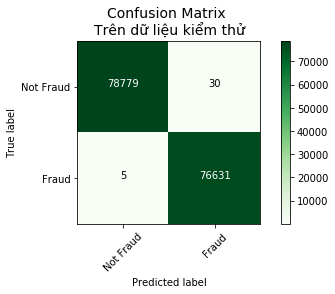

In [0]:
# Confusion matrix: dữ liệu test
actual_cm_test_set = np.mean(conf_matrix_list_of_arrays_test_set, axis=0).astype(int)
labels = ['Not Fraud', 'Fraud']
plot_confusion_matrix(actual_cm_test_set, labels, title="Confusion Matrix \nTrên dữ liệu kiểm thử", cmap=plt.cm.Greens)

###Kết quả

- Có 78779 giao dịch không gian lận được dự đoán đúng là giao dịch không gian lận
- 30 lần giao dịch không gian lận được dự sai đoán là giao dịch gian lận
- 5 lần giao dịch gian lận được dự đoán sai là giao dịch không gian lận
- 76631 lần giao dịch gian lận được dự đoán chính xác là giao dịch gian lận

##9.2 Thuật toán XGBoost và SMOTE + ENN

In [0]:
# Mô hình
model = XGBClassifier(objective="binary:logistic", random_state=42)

# Danh sách confusion matrix của từng lần KFold
conf_matrix_list_of_arrays = []
conf_matrix_list_of_arrays_test_set = []

# Danh sách độ chính xác của từng lần KFold trên dữ liệu test
accuracy_train_set = []
accuracy_test_set = []
f1_score_train = []
f1_score_test = []

# Cross Vallidation: KFold = 3
cv = StratifiedKFold(n_splits=3, random_state=None, shuffle=True)
cv.get_n_splits(X_train, y_train)

# List time train
times_train = []

for train_index, test_index in cv.split(X_train, y_train):
    smote_enn_Xtrain, smote_enn_Xtest = X_train.iloc[train_index], X_train.iloc[test_index]
    smote_enn_ytrain, smote_enn_ytest = y_train.iloc[train_index], y_train.iloc[test_index]

    # Thời gian bắt đầu train
    start_time = timer()

    model.fit(smote_enn_Xtrain, smote_enn_ytrain)
    y_pre_train = model.predict(smote_enn_Xtest)
    y_pre_test = model.predict(X_test)

    # Print the accuracy
    accuracy_train_set.append(
        accuracy_score(smote_enn_ytest, y_pre_train, normalize=True)*100)
    accuracy_test_set.append(
        accuracy_score(y_test, y_pre_test, normalize=True)*100)

    # Confusion matrix
    conf_matrix = confusion_matrix(smote_enn_ytest, y_pre_train)
    conf_matrix_list_of_arrays.append(conf_matrix)
    conf_matrix_2 = confusion_matrix(y_test, y_pre_test)
    conf_matrix_list_of_arrays_test_set.append(conf_matrix_2)

    # F1 score
    f1_score_train.append(f1_score(smote_enn_ytest, y_pre_train))
    f1_score_test.append(f1_score(y_test, y_pre_test))

    # Thời gian kết thúc train
    end_time = timer()
    # Tính thời gian thực hiện
    time_train = (end_time - start_time)
    times_train.append(time_train)

# Độ chính xác của mô hình
print('Độ chính xác của mô hình trên dữ liệu train: ', accuracy_train_set)
print('Độ chính xác của mô hình trên dữ liệu test: ', accuracy_test_set)

print('Độ chính xác trung bình dữ liệu train:', np.mean(accuracy_train_set))
print('Độ chính xác trung bình dữ liệu test:', np.mean(accuracy_test_set))

print('F1 score trung bình trên dữ liệu train:', np.mean(f1_score_train))
print('F1 score trung bình trên dữ liệu test:', np.mean(f1_score_test))

print('Thời gian thực hiện: ', times_train)

Độ chính xác của mô hình trên dữ liệu train:  [98.81557943144504, 98.78992903343203, 98.81887809961786]
Độ chính xác của mô hình trên dữ liệu test:  [98.77127748542902, 98.8208123721421, 98.83367857648315]
Độ chính xác trung bình dữ liệu train: 98.80812885483164
Độ chính xác trung bình dữ liệu test: 98.80858947801808
F1 score trung bình trên dữ liệu train: 0.9878356955109139
F1 score trung bình trên dữ liệu test: 0.9878424625559207
Thời gian thực hiện:  [64.22331461500016, 63.99929814999996, 63.6296117360007]


Confusion matrix, without normalization
[[78352   456]
 [ 1395 75241]]


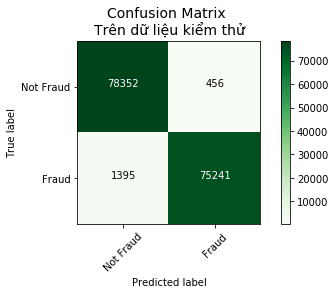

In [0]:
# Confusion matrix: dữ liệu test
actual_cm_test_set = np.mean(conf_matrix_list_of_arrays_test_set, axis=0).astype(int)
labels = ['Not Fraud', 'Fraud']
plot_confusion_matrix(actual_cm_test_set, labels, title="Confusion Matrix \nTrên dữ liệu kiểm thử", cmap=plt.cm.Greens)

###Kết quả

- Có 78352 giao dịch không gian lận được dự đoán đúng là giao dịch không gian lận
- 456 lần giao dịch không gian lận được dự sai đoán là giao dịch gian lận
- 1395 lần giao dịch gian lận được dự đoán sai là giao dịch không gian lận
- 75241 lần giao dịch gian lận được dự đoán chính xác là giao dịch gian lận